# DBSCAN Product Clustering: Complete Evaluation

## Research Question
**Can DBSCAN successfully cluster similar product titles together?**

For example:
- `"apple iphone 8 plus 64gb silver"` → Cluster A
- `"apple iphone 8 plus 64 gb spacegrau"` → Cluster A
- `"apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim free smartphone in gold"` → Cluster A

## Evaluation Strategy
We have **ground truth category labels** from PriceRunner, which allows us to:
1. Measure how well DBSCAN discovers products in the same category (External Metrics: ARI, NMI, etc.)
2. Assess internal cluster quality (Silhouette, Davies-Bouldin)
3. Analyze how DBSCAN handles different category sizes
4. Understand the trade-off between cluster purity and coverage

## Important Design Decision
We **do NOT filter small categories** before clustering because:
- It creates circular logic (using ground truth to preprocess for unsupervised learning)
- It biases evaluation metrics
- It prevents us from seeing how DBSCAN naturally handles outliers
- DBSCAN is designed to identify noise/outliers as part of its algorithm

Instead, we'll analyze performance separately for:
- Large categories (common products)
- Small categories (rare products)
- Overall dataset

---


## 1. Data Loading & Exploration

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score,
    homogeneity_score, completeness_score, v_measure_score
)
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Load full dataset - NO FILTERING
product = pd.read_csv('pricerunner_aggregate.csv')

print("=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)
print(f"Total products: {len(product):,}")
print(f"Total ground truth categories: {product[' Category ID'].nunique()}")
print(f"Columns: {list(product.columns)}")

print(f"\n📊 Ground Truth Category Distribution:")
category_sizes = product[' Category ID'].value_counts()
print(f"  Mean category size: {category_sizes.mean():.2f}")
print(f"  Median category size: {category_sizes.median():.2f}")
print(f"  Min category size: {category_sizes.min()}")
print(f"  Max category size: {category_sizes.max()}")
print(f"  Categories with 1 product: {(category_sizes == 1).sum()}")
print(f"  Categories with 2-3 products: {((category_sizes >= 2) & (category_sizes <= 3)).sum()}")
print(f"  Categories with 4+ products: {(category_sizes >= 4).sum()}")

print(f"\n📝 Sample Products:")
print(product[['Product Title', ' Category ID', ' Category Label']].head(10))
print("=" * 70)


DATASET OVERVIEW
Total products: 35,311
Total ground truth categories: 10
Columns: ['Product ID', 'Product Title', ' Merchant ID', ' Cluster ID', ' Cluster Label', ' Category ID', ' Category Label']

📊 Ground Truth Category Distribution:
  Mean category size: 3531.10
  Median category size: 3574.00
  Min category size: 2212
  Max category size: 5501
  Categories with 1 product: 0
  Categories with 2-3 products: 0
  Categories with 4+ products: 10

📝 Sample Products:
                                       Product Title   Category ID  \
0                    apple iphone 8 plus 64gb silver          2612   
1                apple iphone 8 plus 64 gb spacegrau          2612   
2  apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...          2612   
3                apple iphone 8 plus 64gb space grey          2612   
4  apple iphone 8 plus gold 5.5 64gb 4g unlocked ...          2612   
5  apple iphone 8 plus gold 5.5 64gb 4g unlocked ...          2612   
6               apple iphone 8 plus 64 

### 1.1 Category Distribution Visualization

Visualize how products are distributed across different categories to understand data imbalance and category characteristics.

CATEGORY DISTRIBUTION ANALYSIS

Total unique categories: 10
Total products: 35,311
Average products per category: 3531.10
Median products per category: 3574


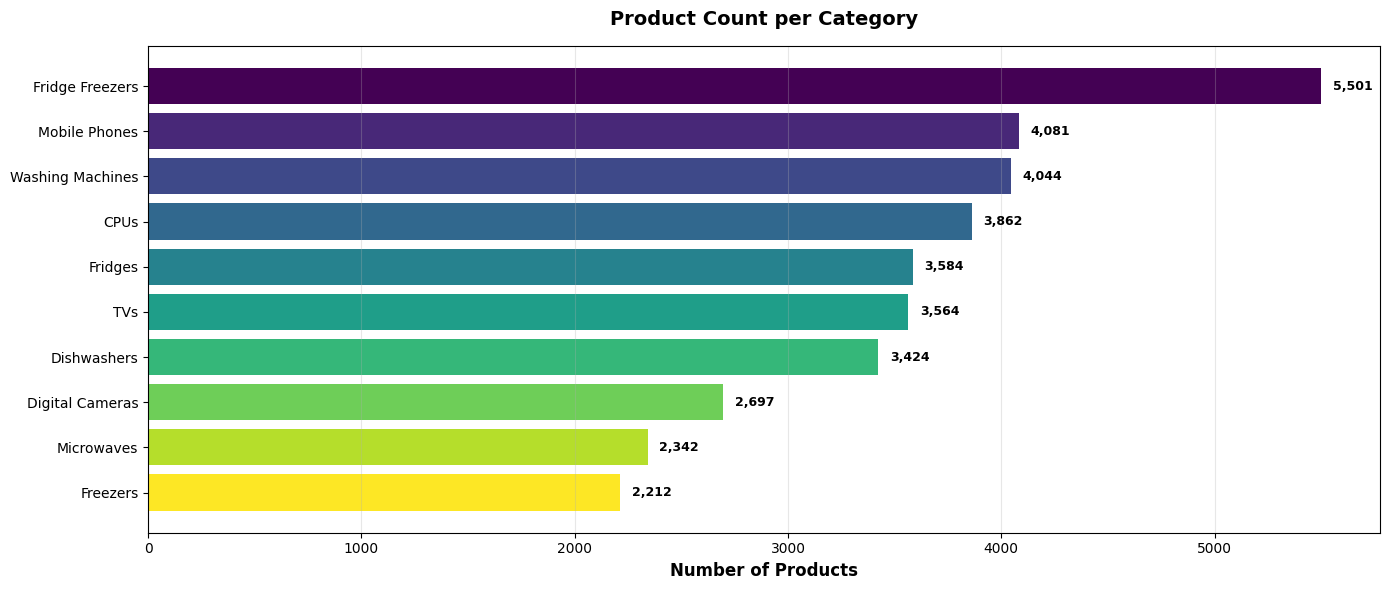


📊 Category Breakdown:
Rank   Category                                           Products   % of Total
--------------------------------------------------------------------------------
1      Fridge Freezers                                    5,501      15.58     %
2      Mobile Phones                                      4,081      11.56     %
3      Washing Machines                                   4,044      11.45     %
4      CPUs                                               3,862      10.94     %
5      Fridges                                            3,584      10.15     %
6      TVs                                                3,564      10.09     %
7      Dishwashers                                        3,424      9.70      %
8      Digital Cameras                                    2,697      7.64      %
9      Microwaves                                         2,342      6.63      %
10     Freezers                                           2,212      6.26      %


In [13]:
# Analyze category distribution
category_counts = product[' Category ID'].value_counts().sort_values(ascending=False)
category_labels = product.groupby(' Category ID')[' Category Label'].first()

print("=" * 80)
print("CATEGORY DISTRIBUTION ANALYSIS")
print("=" * 80)
print(f"\nTotal unique categories: {len(category_counts)}")
print(f"Total products: {len(product):,}")
print(f"Average products per category: {category_counts.mean():.2f}")
print(f"Median products per category: {category_counts.median():.0f}")

# Create bar chart - show all categories since there are only a few
fig, ax = plt.subplots(figsize=(14, max(6, len(category_counts) * 0.4)))

# Get all categories
all_categories = category_counts
all_labels = [category_labels[cat_id] for cat_id in all_categories.index]
colors = plt.cm.viridis(np.linspace(0, 1, len(all_categories)))

# Create horizontal bar chart
bars = ax.barh(range(len(all_categories)), all_categories.values, color=colors)
ax.set_yticks(range(len(all_categories)))
ax.set_yticklabels([f"{label[:50]}..." if len(label) > 50 else label for label in all_labels], fontsize=10)
ax.set_xlabel('Number of Products', fontsize=12, fontweight='bold')
ax.set_title('Product Count per Category', fontsize=14, fontweight='bold', pad=15)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, all_categories.values)):
    ax.text(val + max(all_categories.values)*0.01, i, f'{val:,}', 
             va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Category Breakdown:")
print("=" * 80)
print(f"{'Rank':<6} {'Category':<50} {'Products':<10} {'% of Total':<10}")
print("-" * 80)
for i, (cat_id, count) in enumerate(category_counts.items(), 1):
    label = category_labels[cat_id]
    if len(label) > 47:
        label = label[:47] + "..."
    pct = (count / len(product)) * 100
    print(f"{i:<6} {label:<50} {count:<10,} {pct:<10.2f}%")
print("=" * 80)

## 2. Feature Engineering: TF-IDF Vectorization

Transform product titles into high-dimensional sparse vectors using TF-IDF.

In [14]:
# Create TF-IDF features from product titles
print("Creating TF-IDF features...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=500,  # Limit features for computational efficiency
    min_df=2,          # Ignore rare terms (appear in <2 documents)
    max_df=0.8,        # Ignore common terms (appear in >80% of documents)
    lowercase=True,
    ngram_range=(1, 2) # Include unigrams and bigrams
)

product_features = tfidf_vectorizer.fit_transform(product['Product Title'])

print(f"\n✓ TF-IDF Encoding Complete!")
print(f"  Shape: {product_features.shape}")
print(f"  - {product_features.shape[0]:,} products")
print(f"  - {product_features.shape[1]} features")
print(f"  Sparsity: {(1.0 - product_features.nnz / (product_features.shape[0] * product_features.shape[1])) * 100:.2f}%")
print(f"\n  Sample features: {list(tfidf_vectorizer.get_feature_names_out())[:20]}")

Creating TF-IDF features...

✓ TF-IDF Encoding Complete!
  Shape: (35311, 500)
  - 35,311 products
  - 500 features
  Sparsity: 98.49%

  Sample features: ['10', '1080p', '10kg', '12', '12 place', '1200', '1200 spin', '1200rpm', '128gb', '12mb', '12mb l3', '13', '13 place', '14', '14 place', '1400', '1400 spin', '1400rpm', '1400rpm freestanding', '15']

✓ TF-IDF Encoding Complete!
  Shape: (35311, 500)
  - 35,311 products
  - 500 features
  Sparsity: 98.49%

  Sample features: ['10', '1080p', '10kg', '12', '12 place', '1200', '1200 spin', '1200rpm', '128gb', '12mb', '12mb l3', '13', '13 place', '14', '14 place', '1400', '1400 spin', '1400rpm', '1400rpm freestanding', '15']


## 3. DBSCAN Parameter Tuning

### 3.1 K-Distance Graph for eps Selection

K-DISTANCE ANALYSIS FOR EPS SELECTION
Computing 4-nearest neighbors...
  → Suggested eps for k=4: 0.2760
Computing 6-nearest neighbors...
  → Suggested eps for k=4: 0.2760
Computing 6-nearest neighbors...
  → Suggested eps for k=6: 0.3238
Computing 8-nearest neighbors...
  → Suggested eps for k=6: 0.3238
Computing 8-nearest neighbors...
  → Suggested eps for k=8: 0.3412
Computing 10-nearest neighbors...
  → Suggested eps for k=8: 0.3412
Computing 10-nearest neighbors...
  → Suggested eps for k=10: 0.3496
Computing 12-nearest neighbors...
  → Suggested eps for k=10: 0.3496
Computing 12-nearest neighbors...
  → Suggested eps for k=12: 0.3700
Computing 15-nearest neighbors...
  → Suggested eps for k=12: 0.3700
Computing 15-nearest neighbors...
  → Suggested eps for k=15: 0.3828
Computing 18-nearest neighbors...
  → Suggested eps for k=15: 0.3828
Computing 18-nearest neighbors...
  → Suggested eps for k=18: 0.4038
Computing 21-nearest neighbors...
  → Suggested eps for k=18: 0.4038
Computi

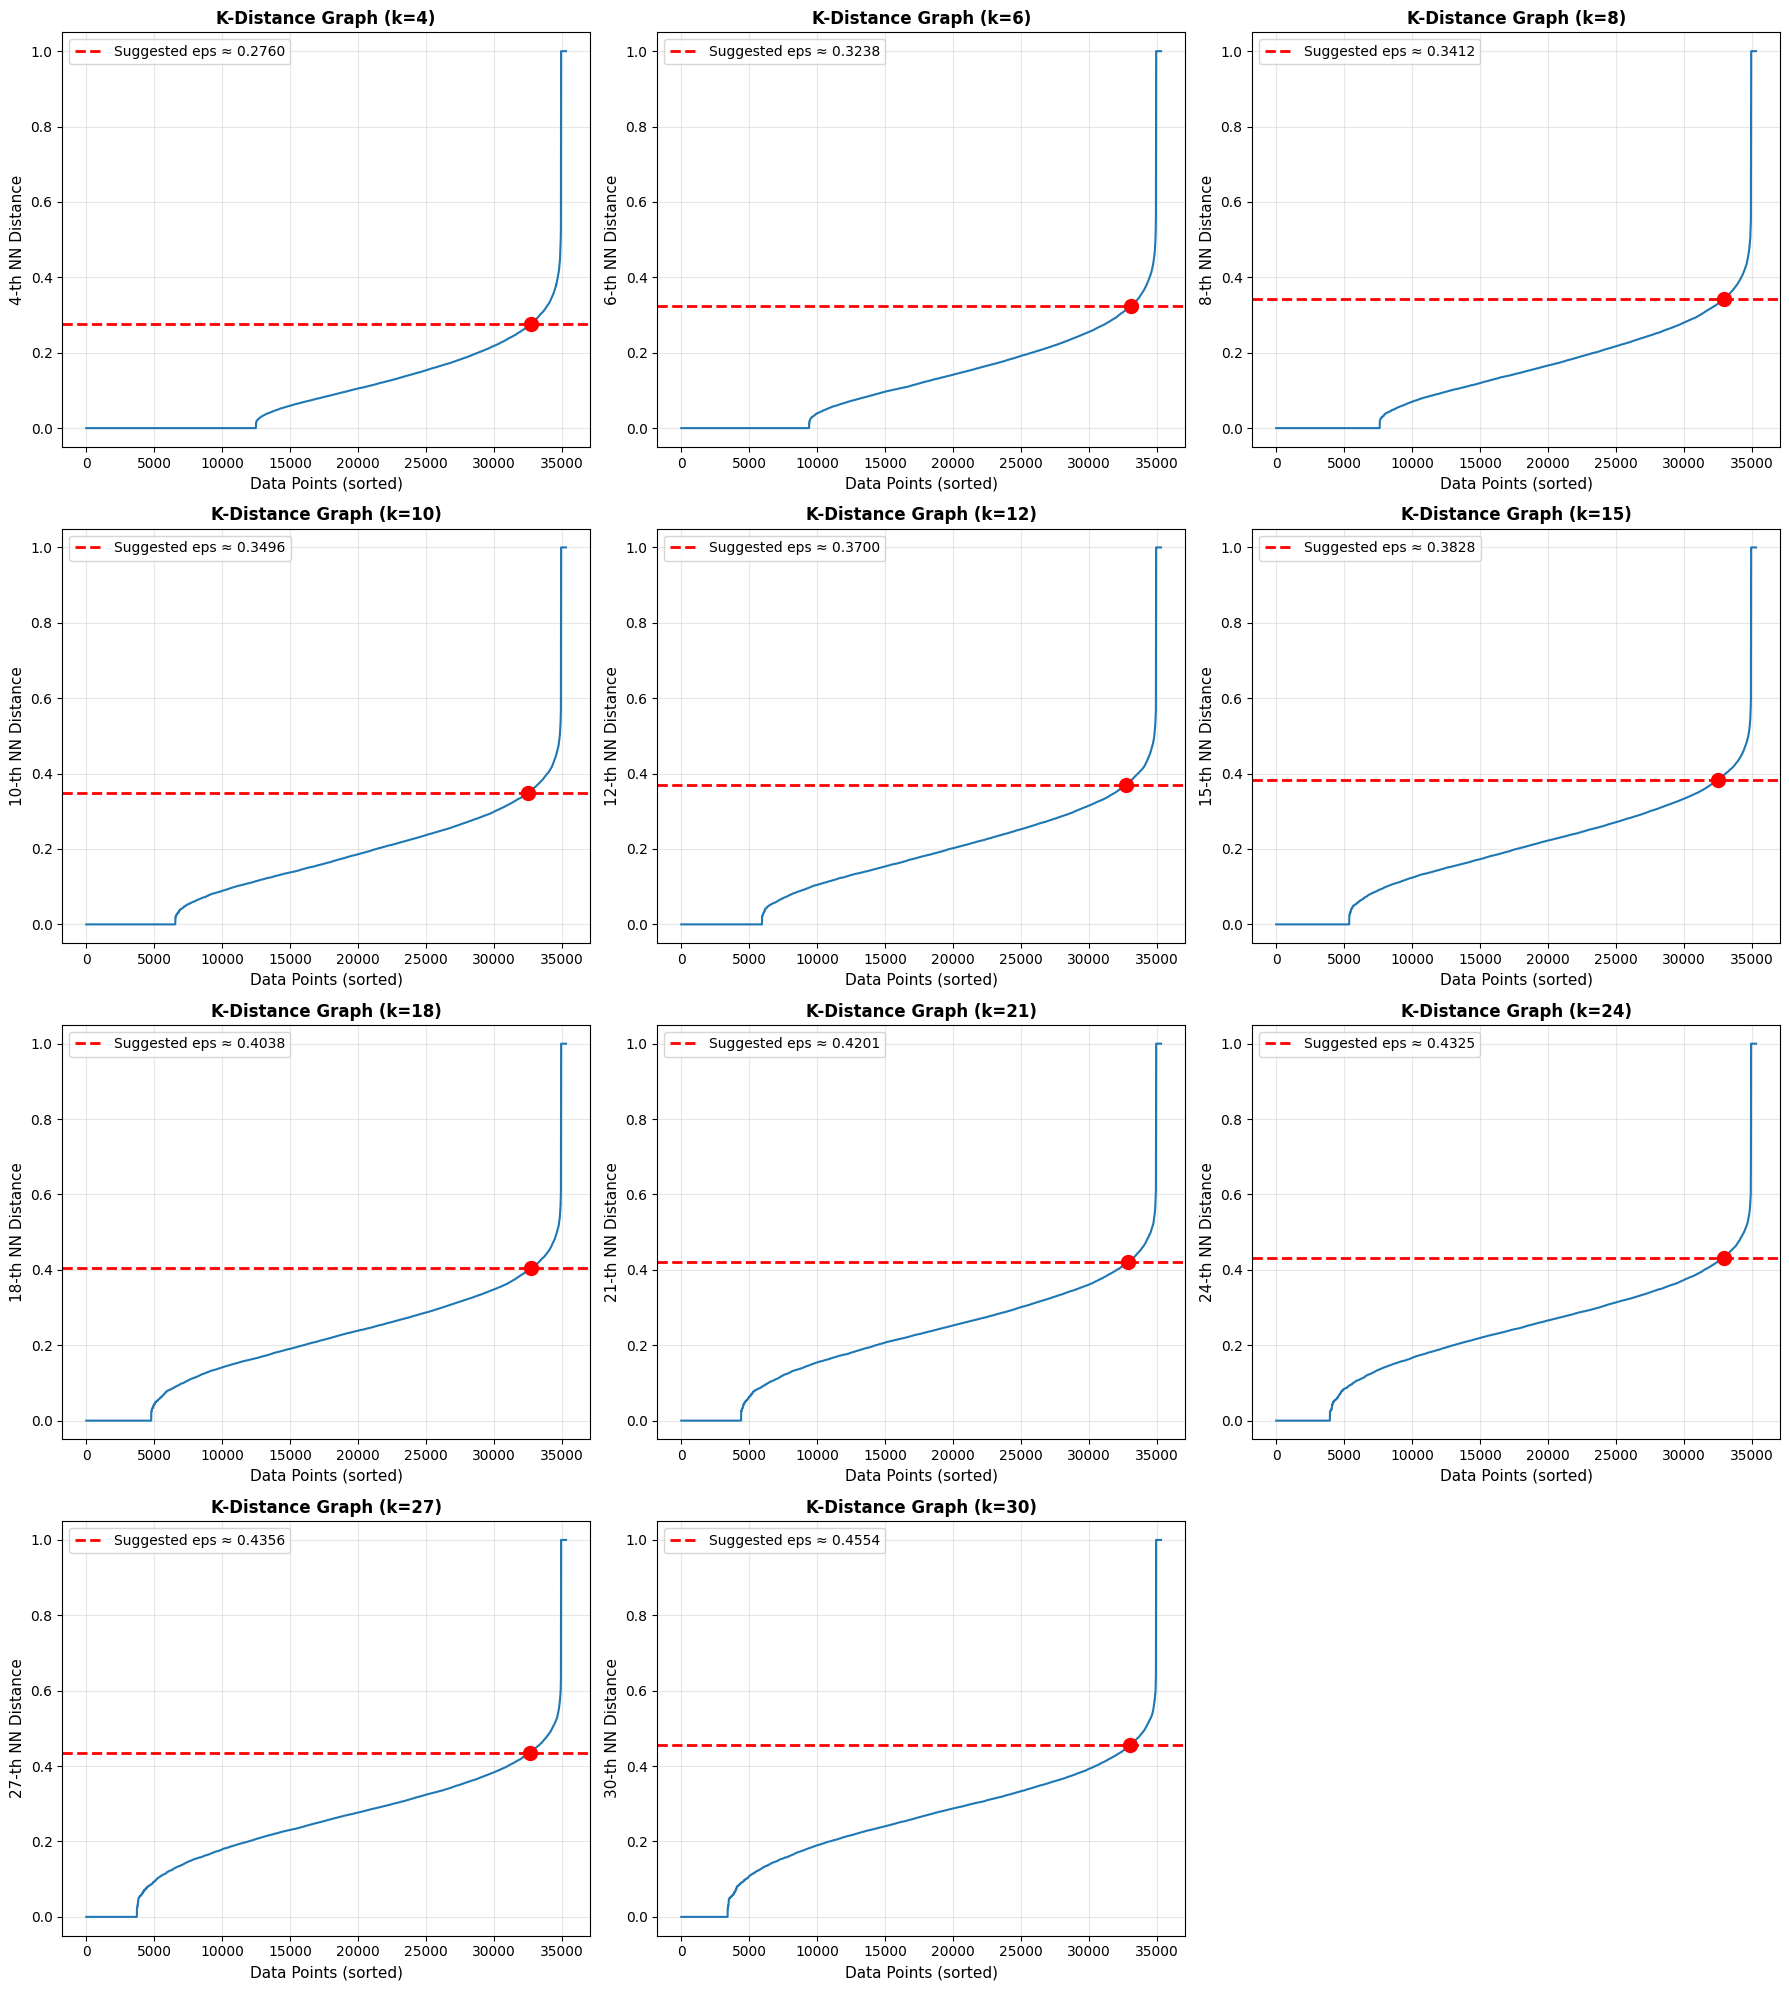


RECOMMENDATIONS:
  min_samples= 4 → eps ≈ 0.2760
  min_samples= 6 → eps ≈ 0.3238
  min_samples= 8 → eps ≈ 0.3412
  min_samples=10 → eps ≈ 0.3496
  min_samples=12 → eps ≈ 0.3700
  min_samples=15 → eps ≈ 0.3828
  min_samples=18 → eps ≈ 0.4038
  min_samples=21 → eps ≈ 0.4201
  min_samples=24 → eps ≈ 0.4325
  min_samples=27 → eps ≈ 0.4356
  min_samples=30 → eps ≈ 0.4554


In [16]:
def plot_k_distance_graph(X, k_values=[4, 6, 8, 10, 12, 15, 18, 21, 24, 27, 30]):
    """
    Plot k-distance graphs to find optimal eps.
    The elbow point suggests the optimal eps value.
    """
    # Calculate grid size for the plots (accommodate all k_values)
    n_plots = len(k_values)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()
    
    recommended_eps = {}
    
    for idx, k in enumerate(k_values):
        print(f"Computing {k}-nearest neighbors...")
        
        neighbors = NearestNeighbors(n_neighbors=k, metric='cosine', n_jobs=-1)
        neighbors.fit(X)
        distances, indices = neighbors.kneighbors(X)
        
        k_distances = np.sort(distances[:, -1])
        
        ax = axes[idx]
        ax.plot(k_distances, linewidth=1.5)
        ax.set_xlabel('Data Points (sorted)', fontsize=11)
        ax.set_ylabel(f'{k}-th NN Distance', fontsize=11)
        ax.set_title(f'K-Distance Graph (k={k})', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Find elbow using perpendicular distance method
        first_point = np.array([0, k_distances[0]])
        last_point = np.array([len(k_distances) - 1, k_distances[-1]])
        line_vec = last_point - first_point
        line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
        vec_from_first = np.array([[i, k_distances[i]] for i in range(len(k_distances))]) - first_point
        distances_to_line = np.abs(np.cross(vec_from_first, line_vec_norm.reshape(1, -1)))
        elbow_idx = np.argmax(distances_to_line)
        elbow_distance = k_distances[elbow_idx]
        
        ax.axhline(y=elbow_distance, color='red', linestyle='--', linewidth=2,
                   label=f'Suggested eps ≈ {elbow_distance:.4f}')
        ax.scatter([elbow_idx], [elbow_distance], color='red', s=100, zorder=5)
        ax.legend(fontsize=10)
        
        recommended_eps[k] = elbow_distance
        print(f"  → Suggested eps for k={k}: {elbow_distance:.4f}")
    
    if len(k_values) < len(axes):
        for idx in range(len(k_values), len(axes)):
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return recommended_eps

print("=" * 70)
print("K-DISTANCE ANALYSIS FOR EPS SELECTION")
print("=" * 70)

eps_recommendations = plot_k_distance_graph(product_features, k_values=[4, 6, 8, 10, 12, 15, 18, 21, 24, 27, 30])

print("\n" + "=" * 70)
print("RECOMMENDATIONS:")
for k, eps in eps_recommendations.items():
    print(f"  min_samples={k:2d} → eps ≈ {eps:.4f}")
print("=" * 70)

### 3.2 Grid Search with Comprehensive Evaluation

In [17]:
def evaluate_dbscan(X, labels_pred, labels_true):
    """
    Comprehensive DBSCAN evaluation.
    """
    metrics = {}
    
    # Count clusters and noise
    n_clusters = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)
    n_noise = list(labels_pred).count(-1)
    n_total = len(labels_pred)
    
    metrics['n_clusters'] = n_clusters
    metrics['n_noise'] = n_noise
    metrics['noise_ratio'] = n_noise / n_total
    
    # Internal metrics (skip if too few clusters or too much noise)
    if n_clusters < 2 or n_noise > n_total * 0.9:
        metrics['silhouette'] = -999
        metrics['davies_bouldin'] = 999
    else:
        mask = labels_pred != -1
        if mask.sum() > 1:
            try:
                metrics['silhouette'] = silhouette_score(X[mask], labels_pred[mask], metric='cosine')
            except:
                metrics['silhouette'] = -999
            
            try:
                X_dense = X[mask].toarray() if hasattr(X[mask], 'toarray') else X[mask]
                metrics['davies_bouldin'] = davies_bouldin_score(X_dense, labels_pred[mask])
            except:
                metrics['davies_bouldin'] = 999
        else:
            metrics['silhouette'] = -999
            metrics['davies_bouldin'] = 999
    
    # External metrics
    try:
        metrics['ari'] = adjusted_rand_score(labels_true, labels_pred)
        metrics['nmi'] = normalized_mutual_info_score(labels_true, labels_pred)
        metrics['homogeneity'] = homogeneity_score(labels_true, labels_pred)
        metrics['completeness'] = completeness_score(labels_true, labels_pred)
        metrics['v_measure'] = v_measure_score(labels_true, labels_pred)
    except:
        metrics['ari'] = -999
        metrics['nmi'] = -999
        metrics['homogeneity'] = -999
        metrics['completeness'] = -999
        metrics['v_measure'] = -999
    
    return metrics

# Define parameter grid
eps_values = sorted(set(eps_recommendations.values()))
eps_min = min(eps_values) * 0.8
eps_max = max(eps_values) * 1.2
eps_grid = np.linspace(eps_min, eps_max, 15)
min_samples_grid = [4, 6, 8, 10, 12, 15, 18, 21, 24, 27, 30]

print("=" * 70)
print("GRID SEARCH CONFIGURATION")
print("=" * 70)
print(f"eps values: {len(eps_grid)} (range: [{eps_min:.4f}, {eps_max:.4f}])")
print(f"min_samples values: {len(min_samples_grid)} {min_samples_grid}")
print(f"Total combinations: {len(eps_grid) * len(min_samples_grid)}")
print("=" * 70)

# Ground truth labels (using Category ID instead of Cluster ID)
labels_true = product[' Category ID'].values

# Grid search
results = []
print("\nRunning grid search...")

for eps in tqdm(eps_grid, desc="eps values"):
    for min_samples in min_samples_grid:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine', n_jobs=-1)
        labels_pred = dbscan.fit_predict(product_features)
        
        metrics = evaluate_dbscan(product_features, labels_pred, labels_true)
        
        result = {'eps': eps, 'min_samples': min_samples, **metrics}
        results.append(result)

results_df = pd.DataFrame(results)
print(f"\n✓ Grid search complete! Evaluated {len(results)} combinations.")


GRID SEARCH CONFIGURATION
eps values: 15 (range: [0.2208, 0.5465])
min_samples values: 11 [4, 6, 8, 10, 12, 15, 18, 21, 24, 27, 30]
Total combinations: 165

Running grid search...


eps values: 100%|██████████| 15/15 [54:06<00:00, 216.43s/it]


✓ Grid search complete! Evaluated 165 combinations.


### 3.3 Select Best Parameters

In [18]:
# Filter valid results
results_valid = results_df[
    (results_df['n_clusters'] >= 2) & 
    (results_df['noise_ratio'] < 0.5) &
    (results_df['silhouette'] > -900)
].copy()

print("=" * 70)
print("RESULTS FILTERING")
print("=" * 70)
print(f"Total combinations: {len(results_df)}")
print(f"Valid combinations: {len(results_valid)}")

if len(results_valid) > 0:
    # Normalize metrics for composite score
    results_valid['ari_norm'] = (results_valid['ari'] - results_valid['ari'].min()) / (results_valid['ari'].max() - results_valid['ari'].min() + 1e-10)
    results_valid['silhouette_norm'] = (results_valid['silhouette'] - results_valid['silhouette'].min()) / (results_valid['silhouette'].max() - results_valid['silhouette'].min() + 1e-10)
    results_valid['noise_norm'] = 1 - results_valid['noise_ratio']
    
    # Composite score (weighted)
    results_valid['composite_score'] = (
        0.40 * results_valid['ari_norm'] +
        0.30 * results_valid['silhouette_norm'] +
        0.30 * results_valid['noise_norm']
    )
    
    # Get best parameters
    best = results_valid.loc[results_valid['composite_score'].idxmax()]
    
    print("\n" + "=" * 70)
    print("🎯 BEST PARAMETERS")
    print("=" * 70)
    print(f"  eps: {best['eps']:.4f}")
    print(f"  min_samples: {int(best['min_samples'])}")
    print(f"\n  Performance:")
    print(f"    ARI: {best['ari']:.4f}")
    print(f"    NMI: {best['nmi']:.4f}")
    print(f"    Silhouette: {best['silhouette']:.4f}")
    print(f"    Clusters: {int(best['n_clusters'])}")
    print(f"    Noise Ratio: {best['noise_ratio']:.2%}")
    print("=" * 70)
    
    # Show top 10
    print("\n📊 Top 10 Parameter Combinations:")
    print(results_valid.nlargest(10, 'composite_score')[[
        'eps', 'min_samples', 'ari', 'nmi', 'silhouette', 'n_clusters', 'noise_ratio', 'composite_score'
    ]].to_string(index=False))
else:
    print("\n⚠️ No valid results found. Consider adjusting parameter ranges.")

RESULTS FILTERING
Total combinations: 165
Valid combinations: 110

🎯 BEST PARAMETERS
  eps: 0.2440
  min_samples: 12

  Performance:
    ARI: 0.3389
    NMI: 0.5528
    Silhouette: -0.0734
    Clusters: 93
    Noise Ratio: 15.76%

📊 Top 10 Parameter Combinations:
     eps  min_samples      ari      nmi  silhouette  n_clusters  noise_ratio  composite_score
0.244026           12 0.338858 0.552797   -0.073399          93     0.157571         0.741595
0.267290           18 0.306735 0.541260   -0.034344          50     0.152134         0.722754
0.220762            8 0.324741 0.520415   -0.076580         189     0.161083         0.722452
0.220762            6 0.334720 0.533695   -0.136062         210     0.130328         0.716872
0.267290           21 0.291862 0.526320   -0.006623          50     0.175215         0.710658
0.267290           24 0.287946 0.522776    0.010209          63     0.198748         0.706498
0.220762           10 0.286382 0.519585    0.005131         180     0.189856  

## 4. Apply Best Parameters & Comprehensive Analysis

In [19]:
if len(results_valid) > 0:
    # Run final DBSCAN
    best_eps = best['eps']
    best_min_samples = int(best['min_samples'])
    
    print(f"Running final DBSCAN with eps={best_eps:.4f}, min_samples={best_min_samples}...")
    
    final_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='cosine', n_jobs=-1)
    final_labels = final_dbscan.fit_predict(product_features)
    
    # Add to dataframe
    product['DBSCAN_Cluster'] = final_labels
    
    # Analysis
    n_clusters_found = len(set(final_labels)) - (1 if -1 in final_labels else 0)
    n_noise = list(final_labels).count(-1)
    
    print("\n" + "=" * 70)
    print("FINAL CLUSTERING RESULTS")
    print("=" * 70)
    print(f"Ground Truth Categories: {product[' Category ID'].nunique()}")
    print(f"DBSCAN Clusters: {n_clusters_found}")
    print(f"Noise Points: {n_noise} ({n_noise/len(final_labels)*100:.1f}%)")
    print(f"Clustered Points: {len(final_labels) - n_noise} ({(1-n_noise/len(final_labels))*100:.1f}%)")
    print("=" * 70)
    
    # Save results
    results_df.to_csv('dbscan_grid_search_results.csv', index=False)
    product.to_csv('pricerunner_dbscan_final_results.csv', index=False)
    print("\n✓ Saved: dbscan_grid_search_results.csv")
    print("✓ Saved: pricerunner_dbscan_final_results.csv")


Running final DBSCAN with eps=0.2440, min_samples=12...

FINAL CLUSTERING RESULTS
Ground Truth Categories: 10
DBSCAN Clusters: 93
Noise Points: 5564 (15.8%)
Clustered Points: 29747 (84.2%)

✓ Saved: dbscan_grid_search_results.csv
✓ Saved: pricerunner_dbscan_final_results.csv

FINAL CLUSTERING RESULTS
Ground Truth Categories: 10
DBSCAN Clusters: 93
Noise Points: 5564 (15.8%)
Clustered Points: 29747 (84.2%)

✓ Saved: dbscan_grid_search_results.csv
✓ Saved: pricerunner_dbscan_final_results.csv


## 5. Stratified Analysis: Large vs Small Ground Truth Categories

Analyze DBSCAN performance separately for common vs rare product categories.


In [32]:
if len(results_valid) > 0:
    # Categorize ground truth categories by size
    gt_category_sizes = product.groupby(' Category ID').size()
    
    large_categories = gt_category_sizes[gt_category_sizes >= 10].index
    medium_categories = gt_category_sizes[(gt_category_sizes >= 4) & (gt_category_sizes < 10)].index
    small_categories = gt_category_sizes[gt_category_sizes < 4].index
    
    print("=" * 70)
    print("STRATIFIED ANALYSIS: Performance by GT Category Size")
    print("=" * 70)
    
    for category_ids, name, description in [
        (large_categories, 'Large', '≥10 products'),
        (medium_categories, 'Medium', '4-9 products'),
        (small_categories, 'Small', '1-3 products')
    ]:
        mask = product[' Category ID'].isin(category_ids)
        subset = product[mask]
        
        if len(subset) > 0:
            subset_labels_true = subset[' Category ID'].values
            subset_labels_pred = subset['DBSCAN_Cluster'].values
            
            noise_ratio = (subset_labels_pred == -1).mean()
            ari = adjusted_rand_score(subset_labels_true, subset_labels_pred)
            nmi = normalized_mutual_info_score(subset_labels_true, subset_labels_pred)
            
            print(f"\n{name} Categories ({description}):")
            print(f"  Products: {len(subset):,} ({len(subset)/len(product)*100:.1f}% of total)")
            print(f"  GT Categories: {len(category_ids)}")
            print(f"  ARI: {ari:.4f}")
            print(f"  NMI: {nmi:.4f}")
            print(f"  Noise Ratio: {noise_ratio:.2%}")
    
    print("\n" + "=" * 70)
    print("KEY INSIGHTS:")
    print("  • Large categories: DBSCAN should perform best here")
    print("  • Medium categories: Moderate performance expected")
    print("  • Small categories: Higher noise ratio is natural/expected")
    print("=" * 70)


STRATIFIED ANALYSIS: Performance by GT Category Size

Large Categories (≥10 products):
  Products: 35,311 (100.0% of total)
  GT Categories: 10
  ARI: 0.3389
  NMI: 0.5528
  Noise Ratio: 15.76%

KEY INSIGHTS:
  • Large categories: DBSCAN should perform best here
  • Medium categories: Moderate performance expected
  • Small categories: Higher noise ratio is natural/expected


## 6. Cluster Purity Analysis

Measure how "pure" each DBSCAN cluster is (what % comes from a single GT category).


CLUSTER PURITY ANALYSIS
Average Purity: 0.811
Median Purity: 0.966

Purity Breakdown:
  Perfect (1.0): 43 clusters (46.2%)
  High (≥0.9): 54 clusters (58.1%)
  Good (≥0.75): 65 clusters (69.9%)

Merging:
  Pure (1 GT): 43 clusters
  Merged (≥2 GT): 50 clusters


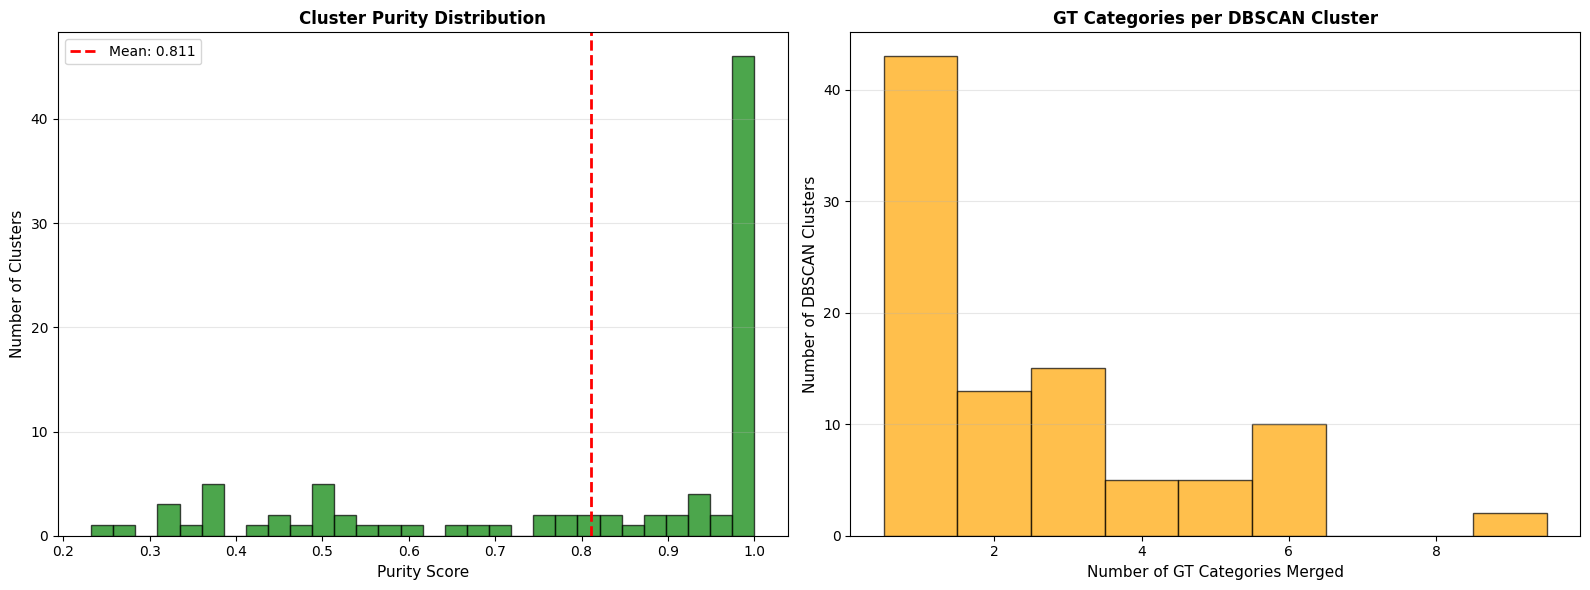


✓ Saved: cluster_purity_analysis.csv


In [21]:
if len(results_valid) > 0:
    # Calculate purity for each DBSCAN cluster
    df_clustered = product[product['DBSCAN_Cluster'] != -1].copy()
    
    purity_results = []
    for cluster_id in sorted(df_clustered['DBSCAN_Cluster'].unique()):
        cluster_data = df_clustered[df_clustered['DBSCAN_Cluster'] == cluster_id]
        gt_distribution = cluster_data[' Category ID'].value_counts()
        
        purity = gt_distribution.iloc[0] / len(cluster_data) if len(cluster_data) > 0 else 0
        
        purity_results.append({
            'DBSCAN_Cluster': cluster_id,
            'Purity': purity,
            'Dominant_GT': gt_distribution.index[0],
            'Size': len(cluster_data),
            'Num_GT_Merged': cluster_data[' Category ID'].nunique()
        })
    
    purity_df = pd.DataFrame(purity_results)
    
    print("=" * 70)
    print("CLUSTER PURITY ANALYSIS")
    print("=" * 70)
    print(f"Average Purity: {purity_df['Purity'].mean():.3f}")
    print(f"Median Purity: {purity_df['Purity'].median():.3f}")
    print(f"\nPurity Breakdown:")
    print(f"  Perfect (1.0): {(purity_df['Purity'] == 1.0).sum()} clusters ({(purity_df['Purity'] == 1.0).mean()*100:.1f}%)")
    print(f"  High (≥0.9): {(purity_df['Purity'] >= 0.9).sum()} clusters ({(purity_df['Purity'] >= 0.9).mean()*100:.1f}%)")
    print(f"  Good (≥0.75): {(purity_df['Purity'] >= 0.75).sum()} clusters ({(purity_df['Purity'] >= 0.75).mean()*100:.1f}%)")
    print(f"\nMerging:")
    print(f"  Pure (1 GT): {(purity_df['Num_GT_Merged'] == 1).sum()} clusters")
    print(f"  Merged (≥2 GT): {(purity_df['Num_GT_Merged'] >= 2).sum()} clusters")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1 = axes[0]
    ax1.hist(purity_df['Purity'], bins=30, color='green', edgecolor='black', alpha=0.7)
    ax1.axvline(purity_df['Purity'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {purity_df['Purity'].mean():.3f}")
    ax1.set_xlabel('Purity Score', fontsize=11)
    ax1.set_ylabel('Number of Clusters', fontsize=11)
    ax1.set_title('Cluster Purity Distribution', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    ax2 = axes[1]
    ax2.hist(purity_df['Num_GT_Merged'], bins=range(1, purity_df['Num_GT_Merged'].max()+2), color='orange', edgecolor='black', alpha=0.7, align='left')
    ax2.set_xlabel('Number of GT Categories Merged', fontsize=11)
    ax2.set_ylabel('Number of DBSCAN Clusters', fontsize=11)
    ax2.set_title('GT Categories per DBSCAN Cluster', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    purity_df.to_csv('cluster_purity_analysis.csv', index=False)
    print("\n✓ Saved: cluster_purity_analysis.csv")


## 7. Cluster Coherence Analysis

Measure how coherent/tight each cluster is using multiple metrics:
- **Intra-cluster distance**: Average cosine distance between points within the same cluster (lower is better)
- **Inter-cluster distance**: Average cosine distance to nearest other cluster (higher is better)
- **Cohesion ratio**: Ratio of intra/inter distance (lower is better)
- **Cluster density**: How tightly packed the cluster is in feature space

### 7.1 Cluster Distribution Analysis

Comprehensive visualization of the 93 clusters' characteristics and distributions.

CLUSTER DISTRIBUTION ANALYSIS - 93 CLUSTERS

Total clusters analyzed: 93
Total products in clusters: 29,747


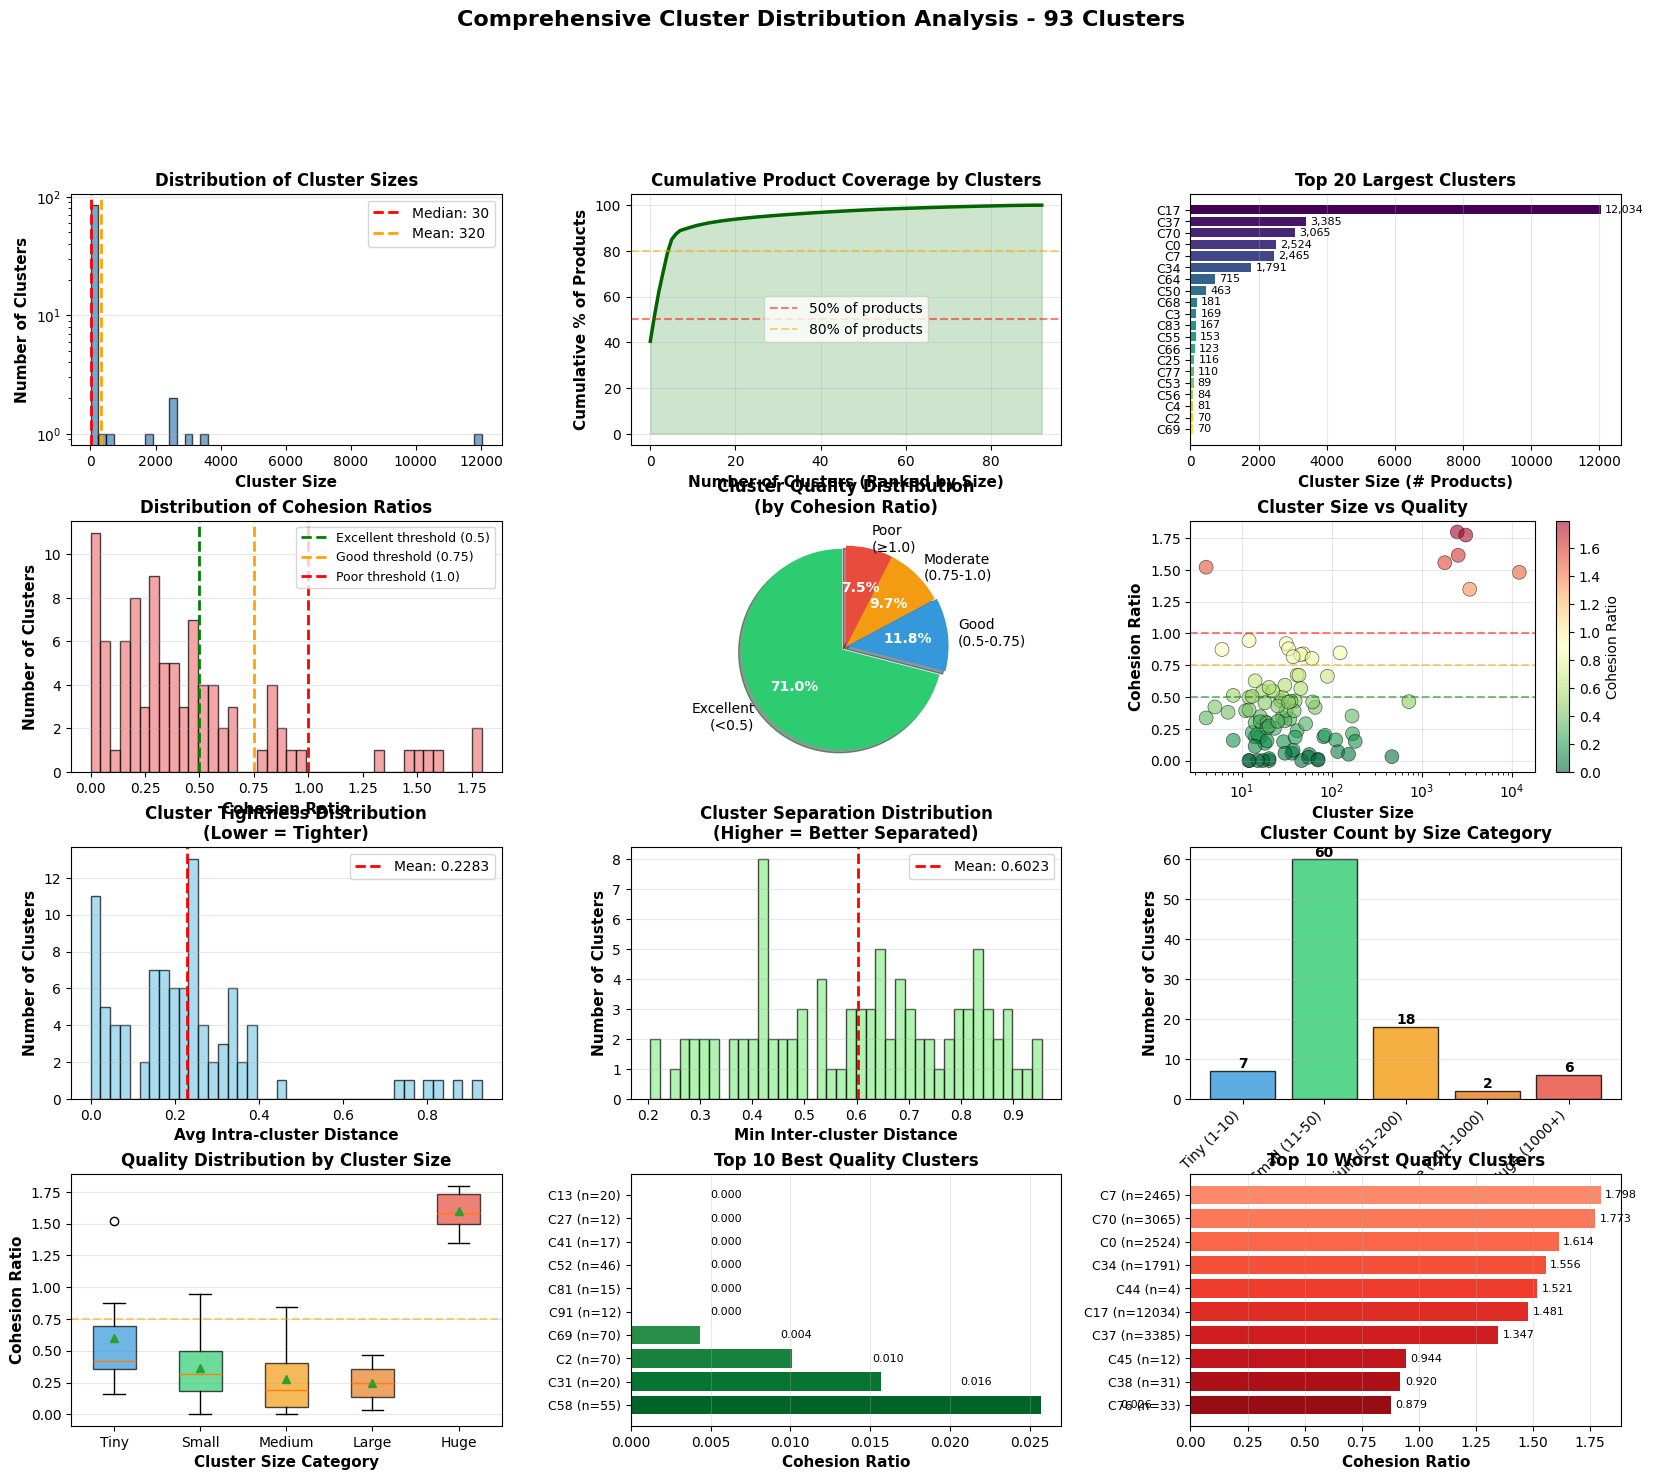


SUMMARY STATISTICS

📏 CLUSTER SIZE:


AttributeError: 'list' object has no attribute 'min'

In [ ]:
if len(results_valid) > 0:
    # Load coherence data
    coherence_dist_df = pd.read_csv('cluster_coherence_analysis.csv')
    
    print("=" * 100)
    print("CLUSTER DISTRIBUTION ANALYSIS - 93 CLUSTERS")
    print("=" * 100)
    print(f"\nTotal clusters analyzed: {len(coherence_dist_df)}")
    print(f"Total products in clusters: {coherence_dist_df['Size'].sum():,}")
    
    # Create visualization with 3 plots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # 1. Cluster Size Distribution (Log scale)
    ax1 = axes[0]
    sizes = coherence_dist_df['Size'].values
    ax1.hist(sizes, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.axvline(np.median(sizes), color='red', linestyle='--', linewidth=2, 
                label=f'Median: {np.median(sizes):.0f}')
    ax1.axvline(np.mean(sizes), color='orange', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(sizes):.0f}')
    ax1.set_xlabel('Cluster Size', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Number of Clusters', fontsize=11, fontweight='bold')
    ax1.set_title('Distribution of Cluster Sizes', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_yscale('log')
    
    # 2. Cluster Size Distribution (Cumulative)
    ax2 = axes[1]
    sorted_sizes = np.sort(sizes)[::-1]
    cumulative_pct = np.cumsum(sorted_sizes) / sorted_sizes.sum() * 100
    ax2.plot(range(len(sorted_sizes)), cumulative_pct, linewidth=2.5, color='darkgreen')
    ax2.axhline(50, color='red', linestyle='--', alpha=0.5, label='50% of products')
    ax2.axhline(80, color='orange', linestyle='--', alpha=0.5, label='80% of products')
    ax2.fill_between(range(len(sorted_sizes)), cumulative_pct, alpha=0.2, color='green')
    ax2.set_xlabel('Number of Clusters (Ranked by Size)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Cumulative % of Products', fontsize=11, fontweight='bold')
    ax2.set_title('Cumulative Product Coverage by Clusters', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Top 20 Largest Clusters
    ax3 = axes[2]
    top_20 = coherence_dist_df.nlargest(20, 'Size')
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_20)))
    bars = ax3.barh(range(len(top_20)), top_20['Size'].values, color=colors)
    ax3.set_yticks(range(len(top_20)))
    ax3.set_yticklabels([f"C{int(c)}" for c in top_20['DBSCAN_Cluster'].values], fontsize=9)
    ax3.set_xlabel('Cluster Size (# Products)', fontsize=11, fontweight='bold')
    ax3.set_title('Top 20 Largest Clusters', fontsize=12, fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(axis='x', alpha=0.3)
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, top_20['Size'].values)):
        ax3.text(val + max(top_20['Size'].values)*0.01, i, f'{val:,}', 
                va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 100)
    print("SUMMARY STATISTICS")
    print("=" * 100)
    
    print(f"\n📏 CLUSTER SIZE:")
    print(f"  Min: {sizes.min()}")
    print(f"  Max: {sizes.max():,}")
    print(f"  Mean: {sizes.mean():.2f}")
    print(f"  Median: {np.median(sizes):.0f}")
    print(f"  Std Dev: {sizes.std():.2f}")
    
    # Find how many clusters contain X% of products
    print(f"\n📦 PRODUCT COVERAGE:")
    for threshold in [50, 80, 90, 95]:
        clusters_needed = np.where(cumulative_pct >= threshold)[0][0] + 1
        print(f"  • {clusters_needed} clusters contain {threshold}% of all products")
    
    print("\n" + "=" * 100)

CLUSTER COHERENCE ANALYSIS
Computing coherence metrics for each cluster...


Analyzing clusters: 100%|██████████| 93/93 [00:01<00:00, 48.84it/s]



COHERENCE STATISTICS

Intra-cluster Distance (lower = more coherent):
  Mean: 0.2283
  Median: 0.2106
  Std: 0.1943

Inter-cluster Distance (higher = more separated):
  Mean: 0.6023
  Median: 0.6293
  Std: 0.1989

Cohesion Ratio (lower = better quality):
  Mean: 0.4404
  Median: 0.3400
  Std: 0.4117

📊 Cluster Quality Breakdown:
  Excellent (ratio < 0.5): 66 clusters (71.0%)
  Good (0.5 ≤ ratio < 0.75): 11 clusters (11.8%)
  Moderate (0.75 ≤ ratio < 1.0): 9 clusters (9.7%)
  Poor (ratio ≥ 1.0): 7 clusters (7.5%)


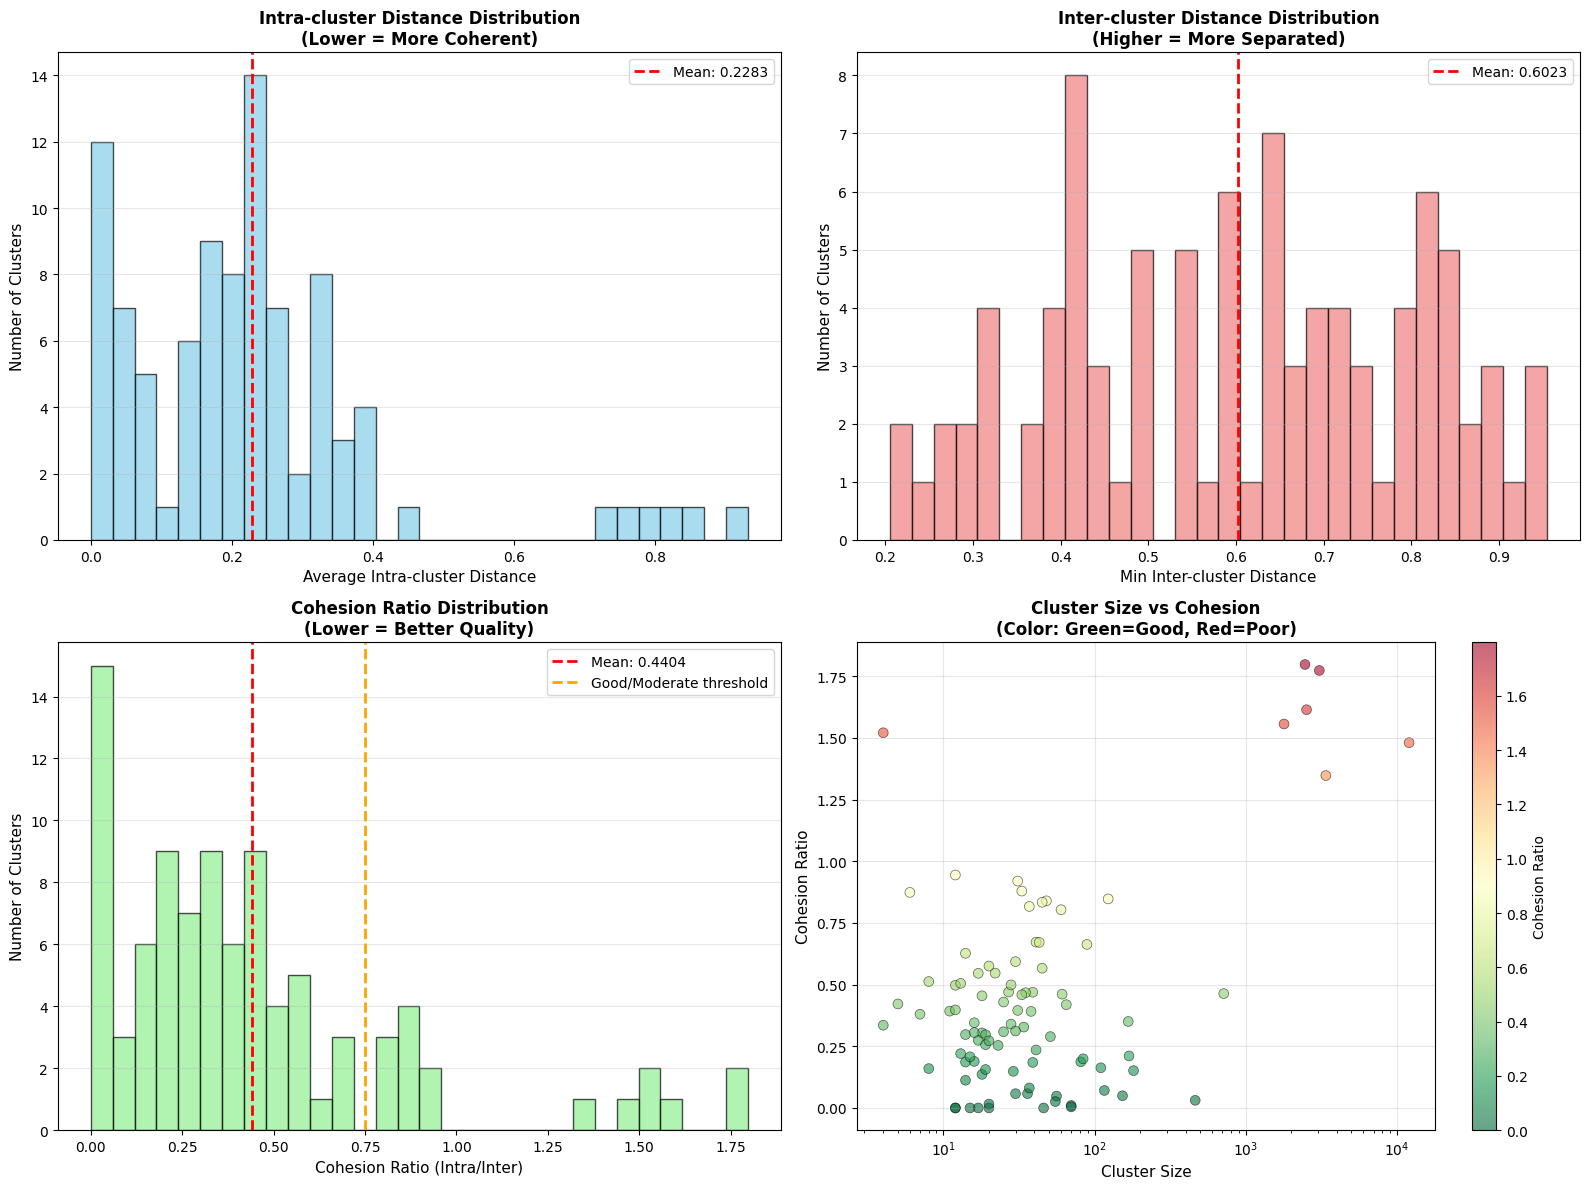


🏆 TOP 10 MOST COHERENT CLUSTERS (Lowest Cohesion Ratio):
 DBSCAN_Cluster  Size  Avg_Intra_Distance  Min_Inter_Distance  Cohesion_Ratio
             13    20            0.000000            0.700256        0.000000
             27    12            0.000000            0.823314        0.000000
             41    17            0.000000            0.734299        0.000000
             52    46            0.000000            0.910179        0.000000
             81    15            0.000000            0.322936        0.000000
             91    12            0.000000            0.640528        0.000000
             69    70            0.003088            0.709024        0.004355
              2    70            0.006412            0.634129        0.010112
             31    20            0.014966            0.954764        0.015675
             58    55            0.024046            0.935408        0.025707

⚠️  TOP 10 LEAST COHERENT CLUSTERS (Highest Cohesion Ratio):
 DBSCAN_Cluster  Size 

In [22]:
if len(results_valid) > 0:
    from scipy.spatial.distance import cdist
    
    print("=" * 70)
    print("CLUSTER COHERENCE ANALYSIS")
    print("=" * 70)
    print("Computing coherence metrics for each cluster...")
    
    df_clustered = product[product['DBSCAN_Cluster'] != -1].copy()
    coherence_results = []
    
    unique_clusters = sorted(df_clustered['DBSCAN_Cluster'].unique())
    
    # Convert features to dense for easier computation (or work with sparse)
    # For large datasets, we'll sample or work with sparse matrices
    
    for cluster_id in tqdm(unique_clusters, desc="Analyzing clusters"):
        cluster_mask = df_clustered['DBSCAN_Cluster'] == cluster_id
        cluster_indices = df_clustered[cluster_mask].index
        cluster_features = product_features[cluster_indices]
        
        cluster_size = len(cluster_indices)
        
        # Skip very small clusters for coherence calculation
        if cluster_size < 2:
            continue
        
        # 1. Intra-cluster cohesion (average pairwise distance within cluster)
        # For computational efficiency, sample if cluster is large
        if cluster_size > 100:
            sample_size = 100
            sample_indices = np.random.choice(cluster_size, sample_size, replace=False)
            cluster_features_sample = cluster_features[sample_indices]
        else:
            cluster_features_sample = cluster_features
        
        # Convert to dense for distance computation
        if hasattr(cluster_features_sample, 'toarray'):
            cluster_features_dense = cluster_features_sample.toarray()
        else:
            cluster_features_dense = cluster_features_sample
        
        # Compute pairwise cosine distances within cluster
        intra_distances = cdist(cluster_features_dense, cluster_features_dense, metric='cosine')
        # Take upper triangle (exclude diagonal and duplicates)
        intra_distances_flat = intra_distances[np.triu_indices_from(intra_distances, k=1)]
        avg_intra_distance = intra_distances_flat.mean() if len(intra_distances_flat) > 0 else 0
        
        # 2. Cluster centroid (mean of all points in cluster)
        cluster_centroid = cluster_features.mean(axis=0)
        if hasattr(cluster_centroid, 'A1'):
            cluster_centroid = cluster_centroid.A1  # Convert matrix to array
        
        # 3. Average distance to centroid
        if hasattr(cluster_features, 'toarray'):
            cluster_features_dense_full = cluster_features.toarray()
        else:
            cluster_features_dense_full = cluster_features
        
        centroid_distances = cdist(cluster_features_dense_full, cluster_centroid.reshape(1, -1), metric='cosine')
        avg_centroid_distance = centroid_distances.mean()
        
        # 4. Inter-cluster separation (distance to nearest other cluster)
        # Find centroid of nearest other cluster
        min_inter_distance = float('inf')
        for other_cluster_id in unique_clusters:
            if other_cluster_id == cluster_id:
                continue
            
            other_cluster_mask = df_clustered['DBSCAN_Cluster'] == other_cluster_id
            other_cluster_indices = df_clustered[other_cluster_mask].index
            other_cluster_features = product_features[other_cluster_indices]
            
            # Compute centroid of other cluster
            other_centroid = other_cluster_features.mean(axis=0)
            if hasattr(other_centroid, 'A1'):
                other_centroid = other_centroid.A1
            
            # Distance between centroids
            inter_distance = cdist(cluster_centroid.reshape(1, -1), 
                                  other_centroid.reshape(1, -1), 
                                  metric='cosine')[0, 0]
            
            min_inter_distance = min(min_inter_distance, inter_distance)
        
        # 5. Cohesion ratio (lower is better - tight cluster far from others)
        cohesion_ratio = avg_intra_distance / min_inter_distance if min_inter_distance > 0 else float('inf')
        
        coherence_results.append({
            'DBSCAN_Cluster': cluster_id,
            'Size': cluster_size,
            'Avg_Intra_Distance': avg_intra_distance,
            'Avg_Centroid_Distance': avg_centroid_distance,
            'Min_Inter_Distance': min_inter_distance,
            'Cohesion_Ratio': cohesion_ratio
        })
    
    coherence_df = pd.DataFrame(coherence_results)
    
    print("\n" + "=" * 70)
    print("COHERENCE STATISTICS")
    print("=" * 70)
    print(f"\nIntra-cluster Distance (lower = more coherent):")
    print(f"  Mean: {coherence_df['Avg_Intra_Distance'].mean():.4f}")
    print(f"  Median: {coherence_df['Avg_Intra_Distance'].median():.4f}")
    print(f"  Std: {coherence_df['Avg_Intra_Distance'].std():.4f}")
    
    print(f"\nInter-cluster Distance (higher = more separated):")
    print(f"  Mean: {coherence_df['Min_Inter_Distance'].mean():.4f}")
    print(f"  Median: {coherence_df['Min_Inter_Distance'].median():.4f}")
    print(f"  Std: {coherence_df['Min_Inter_Distance'].std():.4f}")
    
    print(f"\nCohesion Ratio (lower = better quality):")
    # Filter out inf values for statistics
    valid_ratios = coherence_df[coherence_df['Cohesion_Ratio'] != float('inf')]['Cohesion_Ratio']
    print(f"  Mean: {valid_ratios.mean():.4f}")
    print(f"  Median: {valid_ratios.median():.4f}")
    print(f"  Std: {valid_ratios.std():.4f}")
    
    print(f"\n📊 Cluster Quality Breakdown:")
    excellent = (valid_ratios < 0.5).sum()
    good = ((valid_ratios >= 0.5) & (valid_ratios < 0.75)).sum()
    moderate = ((valid_ratios >= 0.75) & (valid_ratios < 1.0)).sum()
    poor = (valid_ratios >= 1.0).sum()
    
    print(f"  Excellent (ratio < 0.5): {excellent} clusters ({excellent/len(valid_ratios)*100:.1f}%)")
    print(f"  Good (0.5 ≤ ratio < 0.75): {good} clusters ({good/len(valid_ratios)*100:.1f}%)")
    print(f"  Moderate (0.75 ≤ ratio < 1.0): {moderate} clusters ({moderate/len(valid_ratios)*100:.1f}%)")
    print(f"  Poor (ratio ≥ 1.0): {poor} clusters ({poor/len(valid_ratios)*100:.1f}%)")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Intra-cluster distances
    ax1 = axes[0, 0]
    ax1.hist(coherence_df['Avg_Intra_Distance'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax1.axvline(coherence_df['Avg_Intra_Distance'].mean(), color='red', linestyle='--', linewidth=2,
                label=f"Mean: {coherence_df['Avg_Intra_Distance'].mean():.4f}")
    ax1.set_xlabel('Average Intra-cluster Distance', fontsize=11)
    ax1.set_ylabel('Number of Clusters', fontsize=11)
    ax1.set_title('Intra-cluster Distance Distribution\n(Lower = More Coherent)', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Inter-cluster distances
    ax2 = axes[0, 1]
    ax2.hist(coherence_df['Min_Inter_Distance'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    ax2.axvline(coherence_df['Min_Inter_Distance'].mean(), color='red', linestyle='--', linewidth=2,
                label=f"Mean: {coherence_df['Min_Inter_Distance'].mean():.4f}")
    ax2.set_xlabel('Min Inter-cluster Distance', fontsize=11)
    ax2.set_ylabel('Number of Clusters', fontsize=11)
    ax2.set_title('Inter-cluster Distance Distribution\n(Higher = More Separated)', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Cohesion ratio
    ax3 = axes[1, 0]
    valid_coherence = coherence_df[coherence_df['Cohesion_Ratio'] != float('inf')]
    ax3.hist(valid_coherence['Cohesion_Ratio'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
    ax3.axvline(valid_ratios.mean(), color='red', linestyle='--', linewidth=2,
                label=f"Mean: {valid_ratios.mean():.4f}")
    ax3.axvline(0.75, color='orange', linestyle='--', linewidth=2, label='Good/Moderate threshold')
    ax3.set_xlabel('Cohesion Ratio (Intra/Inter)', fontsize=11)
    ax3.set_ylabel('Number of Clusters', fontsize=11)
    ax3.set_title('Cohesion Ratio Distribution\n(Lower = Better Quality)', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Scatter: Cluster size vs coherence
    ax4 = axes[1, 1]
    valid_coherence = coherence_df[coherence_df['Cohesion_Ratio'] != float('inf')]
    scatter = ax4.scatter(valid_coherence['Size'], valid_coherence['Cohesion_Ratio'],
                         c=valid_coherence['Cohesion_Ratio'], cmap='RdYlGn_r',
                         s=50, alpha=0.6, edgecolor='black', linewidth=0.5)
    ax4.set_xlabel('Cluster Size', fontsize=11)
    ax4.set_ylabel('Cohesion Ratio', fontsize=11)
    ax4.set_title('Cluster Size vs Cohesion\n(Color: Green=Good, Red=Poor)', fontsize=12, fontweight='bold')
    ax4.set_xscale('log')
    ax4.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax4, label='Cohesion Ratio')
    
    plt.tight_layout()
    plt.show()
    
    # Show best and worst clusters
    print("\n" + "=" * 70)
    print("🏆 TOP 10 MOST COHERENT CLUSTERS (Lowest Cohesion Ratio):")
    print("=" * 70)
    best_clusters = valid_coherence.nsmallest(10, 'Cohesion_Ratio')[
        ['DBSCAN_Cluster', 'Size', 'Avg_Intra_Distance', 'Min_Inter_Distance', 'Cohesion_Ratio']
    ]
    print(best_clusters.to_string(index=False))
    
    print("\n" + "=" * 70)
    print("⚠️  TOP 10 LEAST COHERENT CLUSTERS (Highest Cohesion Ratio):")
    print("=" * 70)
    worst_clusters = valid_coherence.nlargest(10, 'Cohesion_Ratio')[
        ['DBSCAN_Cluster', 'Size', 'Avg_Intra_Distance', 'Min_Inter_Distance', 'Cohesion_Ratio']
    ]
    print(worst_clusters.to_string(index=False))
    
    # Save results
    coherence_df.to_csv('cluster_coherence_analysis.csv', index=False)
    print("\n✓ Saved: cluster_coherence_analysis.csv")
    
    print("\n" + "=" * 70)
    print("INTERPRETATION:")
    print("=" * 70)
    print("  • Intra-cluster distance: How similar products are within a cluster")
    print("  • Inter-cluster distance: How different clusters are from each other")
    print("  • Cohesion ratio < 0.75: Well-separated, coherent clusters")
    print("  • Cohesion ratio ≥ 1.0: Clusters may overlap or be diffuse")
    print("=" * 70)

## 8. Sample Cluster Examples

Examine actual product titles to validate semantic coherence.

In [23]:
if len(results_valid) > 0 and len(purity_df) > 0:
    # High purity cluster
    high_purity = purity_df.nlargest(1, 'Purity').iloc[0]
    cluster_id = high_purity['DBSCAN_Cluster']
    
    print("=" * 70)
    print(f"EXAMPLE 1: High-Purity Cluster (DBSCAN Cluster {cluster_id})")
    print(f"Purity: {high_purity['Purity']:.3f} | Size: {high_purity['Size']} products")
    print("=" * 70)
    
    sample_titles = product[product['DBSCAN_Cluster'] == cluster_id]['Product Title'].head(15)
    for i, title in enumerate(sample_titles, 1):
        print(f"{i:2d}. {title}")
    
    # Merged cluster
    if (purity_df['Num_GT_Merged'] >= 3).any():
        merged = purity_df[purity_df['Num_GT_Merged'] >= 3].nlargest(1, 'Size').iloc[0]
        cluster_id = merged['DBSCAN_Cluster']
        
        print(f"\n\n" + "=" * 70)
        print(f"EXAMPLE 2: Merged Cluster (DBSCAN Cluster {cluster_id})")
        print(f"Purity: {merged['Purity']:.3f} | Size: {merged['Size']} | Merges {merged['Num_GT_Merged']} GT clusters")
        print("=" * 70)
        
        sample_titles = product[product['DBSCAN_Cluster'] == cluster_id]['Product Title'].sample(min(15, merged['Size']))
        for i, title in enumerate(sample_titles, 1):
            print(f"{i:2d}. {title}")
    
    # Noise examples
    noise_products = product[product['DBSCAN_Cluster'] == -1]
    if len(noise_products) > 0:
        print(f"\n\n" + "=" * 70)
        print(f"EXAMPLE 3: Noise Points ({len(noise_products)} total)")
        print("=" * 70)
        
        sample_noise = noise_products['Product Title'].sample(min(15, len(noise_products)))
        for i, title in enumerate(sample_noise, 1):
            print(f"{i:2d}. {title}")

EXAMPLE 1: High-Purity Cluster (DBSCAN Cluster 1.0)
Purity: 1.000 | Size: 28.0 products
 1. iphone 7 32gb black
 2. iphone 7 32gb black mn8x2b/a wc01
 3. mob/blackberry/keyone 4.5 32gb 12mp
 4. lg g6 32gb astro black
 5. cat s60 32gb black
 6. cat s60 thermal imaging rugged 32gb smartphone
 7. lg q6 32gb black
 8. google pixel xl 32gb black smartphone
 9. xiaomi redmi 6 32gb black
10. blackberry dtek60 32gb black
11. moto g6 32gb silver
12. xiaomi mi a2 lite 32gb black
13. xiaomi redmi note 5 32gb black
14. xiaomi 6a redmi 32gb dunkel grau
15. alcatel 3x 32gb metallic black


EXAMPLE 2: Merged Cluster (DBSCAN Cluster 17.0)
Purity: 0.359 | Size: 12034.0 | Merges 9.0 GT clusters
 1. lec r5010w undercounter fridge with freezer compartment white
 2. fridgemaster mtz55160 55cm wide freestanding upright freezer white
 3. baumatic bruf103 60cm wide integrated upright under counter freezer white
 4. bosch kge49bi30g serie 6 low frost fridge freezer stainless steel
 5. liebherr gp 1213 under co

## 9. Final Summary & Conclusions

In [24]:
if len(results_valid) > 0:
    print("=" * 100)
    print("FINAL EVALUATION SUMMARY")
    print("=" * 100)
    
    print(f"\n🔧 SELECTED PARAMETERS:")
    print(f"  eps: {best['eps']:.4f}")
    print(f"  min_samples: {int(best['min_samples'])}")
    
    print(f"\n📊 CLUSTERING RESULTS:")
    print(f"  Ground Truth Categories: {product[' Category ID'].nunique()}")
    print(f"  DBSCAN Clusters: {int(best['n_clusters'])}")
    print(f"  Reduction: {(1 - int(best['n_clusters'])/product[' Category ID'].nunique())*100:.1f}%")
    
    print(f"\n🎯 EXTERNAL VALIDATION (vs Ground Truth):")
    print(f"  ARI (Adjusted Rand Index): {best['ari']:.4f}")
    print(f"  NMI (Normalized Mutual Info): {best['nmi']:.4f}")
    print(f"  V-Measure: {best['v_measure']:.4f}")
    print(f"  Homogeneity: {best['homogeneity']:.4f}")
    print(f"  Completeness: {best['completeness']:.4f}")
    
    print(f"\n📈 INTERNAL QUALITY:")
    print(f"  Silhouette Score: {best['silhouette']:.4f}")
    print(f"  Davies-Bouldin Index: {best['davies_bouldin']:.4f}")
    
    print(f"\n🔴 NOISE HANDLING:")
    print(f"  Noise Points: {int(best['n_noise']):,} ({best['noise_ratio']*100:.1f}%)")
    print(f"  Clustered Points: {len(product) - int(best['n_noise']):,} ({(1-best['noise_ratio'])*100:.1f}%)")
    
    print(f"\n💎 CLUSTER PURITY:")
    print(f"  Average Purity: {purity_df['Purity'].mean():.3f}")
    print(f"  High Purity (≥0.9): {(purity_df['Purity'] >= 0.9).mean()*100:.1f}% of clusters")
    
    print(f"\n💡 INTERPRETATION:")
    if best['ari'] > 0.5:
        print(f"  ✅ EXCELLENT: DBSCAN successfully clusters products by category")
    elif best['ari'] > 0.3:
        print(f"  ✓ GOOD: DBSCAN captures meaningful category-based similarities")
    else:
        print(f"  ⚠️ MODERATE: DBSCAN partially captures category-based similarities")
    
    if purity_df['Purity'].mean() > 0.8:
        print(f"  ✅ High cluster purity indicates semantically coherent clusters")
    
    if best['noise_ratio'] < 0.3:
        print(f"  ✅ Reasonable noise ratio - most products are clustered")
    elif best['noise_ratio'] < 0.5:
        print(f"  ✓ Moderate noise ratio - acceptable for density-based clustering")
    else:
        print(f"  ⚠️ High noise ratio - consider adjusting parameters")
    
    print(f"\n🎓 CONCLUSION:")
    print(f"  DBSCAN {'CAN' if best['ari'] > 0.3 else 'PARTIALLY CAN'} cluster products by category based on titles.")
    print(f"  The algorithm finds {int(best['n_clusters'])} natural clusters with {purity_df['Purity'].mean():.1%} average purity.")
    print(f"  Trade-off: Higher cluster quality vs lower coverage (noise).")
    
    print("\n" + "=" * 100)
    print("✅ EVALUATION COMPLETE")
    print("=" * 100)
else:
    print("\n⚠️ Evaluation incomplete - no valid parameters found.")


FINAL EVALUATION SUMMARY

🔧 SELECTED PARAMETERS:
  eps: 0.2440
  min_samples: 12

📊 CLUSTERING RESULTS:
  Ground Truth Categories: 10
  DBSCAN Clusters: 93
  Reduction: -830.0%

🎯 EXTERNAL VALIDATION (vs Ground Truth):
  ARI (Adjusted Rand Index): 0.3389
  NMI (Normalized Mutual Info): 0.5528
  V-Measure: 0.5528
  Homogeneity: 0.5639
  Completeness: 0.5421

📈 INTERNAL QUALITY:
  Silhouette Score: -0.0734
  Davies-Bouldin Index: 1.6258

🔴 NOISE HANDLING:
  Noise Points: 5,564 (15.8%)
  Clustered Points: 29,747 (84.2%)

💎 CLUSTER PURITY:
  Average Purity: 0.811
  High Purity (≥0.9): 58.1% of clusters

💡 INTERPRETATION:
  ✓ GOOD: DBSCAN captures meaningful category-based similarities
  ✅ High cluster purity indicates semantically coherent clusters
  ✅ Reasonable noise ratio - most products are clustered

🎓 CONCLUSION:
  DBSCAN CAN cluster products by category based on titles.
  The algorithm finds 93 natural clusters with 81.1% average purity.
  Trade-off: Higher cluster quality vs lower 

---

## 10. Qualitative Cluster Evaluation

Beyond quantitative metrics, let's manually inspect clusters to assess semantic coherence.

### 10.1 Cluster Size Distribution

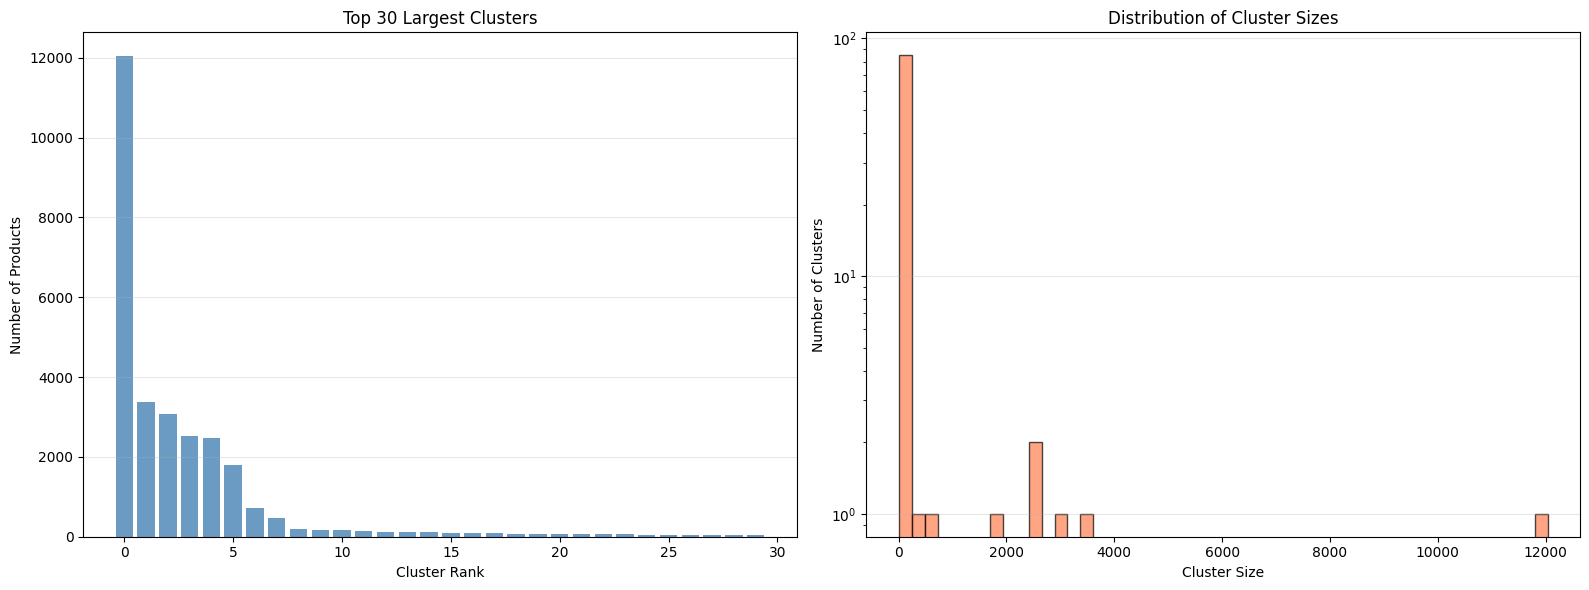

CLUSTER SIZE STATISTICS
Total clusters (excluding noise): 93
Largest cluster: 12034 products
Smallest cluster: 4 products
Mean cluster size: 319.86 products
Median cluster size: 30 products

Cluster size percentiles:
  25th percentile: 16 products
  50th percentile: 30 products
  75th percentile: 56 products
  90th percentile: 169 products
  95th percentile: 2061 products
  99th percentile: 4077 products


In [25]:
if len(results_valid) > 0:
    # Analyze cluster size distribution
    cluster_sizes = product['DBSCAN_Cluster'].value_counts().sort_values(ascending=False)
    cluster_sizes_no_noise = cluster_sizes[cluster_sizes.index != -1]

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Top 30 largest clusters
    ax1 = axes[0]
    top_30 = cluster_sizes_no_noise.head(30)
    ax1.bar(range(len(top_30)), top_30.values, color='steelblue', alpha=0.8)
    ax1.set_xlabel('Cluster Rank')
    ax1.set_ylabel('Number of Products')
    ax1.set_title('Top 30 Largest Clusters')
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: Cluster size histogram
    ax2 = axes[1]
    ax2.hist(cluster_sizes_no_noise.values, bins=50, color='coral', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Cluster Size')
    ax2.set_ylabel('Number of Clusters')
    ax2.set_title('Distribution of Cluster Sizes')
    ax2.set_yscale('log')  # Log scale to see small clusters
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistics
    print("=" * 80)
    print("CLUSTER SIZE STATISTICS")
    print("=" * 80)
    print(f"Total clusters (excluding noise): {len(cluster_sizes_no_noise)}")
    print(f"Largest cluster: {cluster_sizes_no_noise.max()} products")
    print(f"Smallest cluster: {cluster_sizes_no_noise.min()} products")
    print(f"Mean cluster size: {cluster_sizes_no_noise.mean():.2f} products")
    print(f"Median cluster size: {cluster_sizes_no_noise.median():.0f} products")
    print(f"\nCluster size percentiles:")
    for p in [25, 50, 75, 90, 95, 99]:
        print(f"  {p}th percentile: {cluster_sizes_no_noise.quantile(p/100):.0f} products")
    print("=" * 80)

### 10.2 Inspect Sample Clusters - Large Clusters

Let's examine large clusters to see if they make sense.

In [26]:
if len(results_valid) > 0:
    # Function to display cluster details
    def inspect_cluster(cluster_id, n_samples=10):
        """Display detailed information about a specific cluster"""
        cluster_data = product[product['DBSCAN_Cluster'] == cluster_id]
        
        print("=" * 100)
        print(f"CLUSTER {cluster_id} | Size: {len(cluster_data)} products")
        print("=" * 100)
        
        # Show ground truth category distribution within this DBSCAN cluster
        gt_distribution = cluster_data[' Category ID'].value_counts().head(5)
        print(f"\nTop 5 Ground Truth Categories in this DBSCAN cluster:")
        for gt_id, count in gt_distribution.items():
            pct = (count / len(cluster_data)) * 100
            gt_label = cluster_data[cluster_data[' Category ID'] == gt_id][' Category Label'].iloc[0]
            print(f"  • GT Category {gt_id} ({gt_label}): {count} products ({pct:.1f}%)")
        
        # Sample products
        print(f"\n📦 Sample Products (showing {min(n_samples, len(cluster_data))} of {len(cluster_data)}):")
        print("-" * 100)
        
        sample = cluster_data.sample(n=min(n_samples, len(cluster_data)), random_state=42)
        for idx, (_, row) in enumerate(sample.iterrows(), 1):
            print(f"{idx:2d}. {row['Product Title']}")
            print(f"    └─ GT: Category {row[' Category ID']} ({row[' Category Label']})")
        
        print("=" * 100)
        return cluster_data

    # Inspect the 5 largest clusters
    print("\n🔍 INSPECTING TOP 5 LARGEST CLUSTERS\n")
    top_5_clusters = cluster_sizes_no_noise.head(5).index

    for i, cluster_id in enumerate(top_5_clusters, 1):
        print(f"\n{'#' * 100}")
        print(f"#{' ' * 43}LARGE CLUSTER #{i}{' ' * 43}#")
        print(f"{'#' * 100}\n")
        _ = inspect_cluster(cluster_id, n_samples=15)



🔍 INSPECTING TOP 5 LARGEST CLUSTERS


####################################################################################################
#                                           LARGE CLUSTER #1                                           #
####################################################################################################

CLUSTER 17 | Size: 12034 products

Top 5 Ground Truth Categories in this DBSCAN cluster:
  • GT Category 2622 (Fridge Freezers): 4321 products (35.9%)
  • GT Category 2623 (Fridges): 2380 products (19.8%)
  • GT Category 2619 (Dishwashers): 1966 products (16.3%)
  • GT Category 2621 (Freezers): 1603 products (13.3%)
  • GT Category 2618 (Microwaves): 1547 products (12.9%)

📦 Sample Products (showing 15 of 12034):
----------------------------------------------------------------------------------------------------
 1. b2850 liebherr freezer 60cm bluperformance white under counter a
    └─ GT: Category 2623 (Fridges)
 2. siemens ki82laf30 einbau k 

### 10.3 Inspect Sample Clusters - Medium & Small Clusters

Check if smaller clusters have better coherence.

In [27]:
if len(results_valid) > 0:
    # Sample clusters from different size ranges
    print("🔍 INSPECTING CLUSTERS FROM DIFFERENT SIZE RANGES\n")

    # Define size ranges
    size_ranges = [
        ("Medium (10-30 products)", 10, 30, 3),
        ("Small (4-9 products)", 4, 9, 3),
        ("Tiny (3 products)", 3, 3, 2)
    ]

    for range_name, min_size, max_size, n_samples_to_show in size_ranges:
        # Find clusters in this range
        clusters_in_range = cluster_sizes_no_noise[
            (cluster_sizes_no_noise >= min_size) & 
            (cluster_sizes_no_noise <= max_size)
        ]
        
        if len(clusters_in_range) == 0:
            print(f"\n⚠️  No clusters found in range: {range_name}")
            continue
        
        print(f"\n{'#' * 100}")
        print(f"#{' ' * 35}{range_name.upper()}{' ' * (63-len(range_name))}#")
        print(f"#{' ' * 40}({len(clusters_in_range)} clusters){' ' * 40}#")
        print(f"{'#' * 100}\n")
        
        # Sample random clusters from this range
        sample_clusters = clusters_in_range.sample(n=min(n_samples_to_show, len(clusters_in_range)), random_state=42)
        
        for i, (cluster_id, size) in enumerate(sample_clusters.items(), 1):
            print(f"\n--- Sample {i}/{min(n_samples_to_show, len(clusters_in_range))} ---\n")
            _ = inspect_cluster(cluster_id, n_samples=size)  # Show all products in small clusters

🔍 INSPECTING CLUSTERS FROM DIFFERENT SIZE RANGES


####################################################################################################
#                                   MEDIUM (10-30 PRODUCTS)                                        #
#                                        (41 clusters)                                        #
####################################################################################################


--- Sample 1/3 ---

CLUSTER 60 | Size: 16 products

Top 5 Ground Truth Categories in this DBSCAN cluster:
  • GT Category 2618 (Microwaves): 11 products (68.8%)
  • GT Category 2612 (Mobile Phones): 2 products (12.5%)
  • GT Category 2617 (Digital Cameras): 2 products (12.5%)
  • GT Category 2621 (Freezers): 1 products (6.2%)

📦 Sample Products (showing 16 of 16):
----------------------------------------------------------------------------------------------------
 1. one touch 6050y idol 2s slate eng
    └─ GT: Category 2612 (Mobile Phones)
 

### 10.4 Analyze Noise Points

Are products labeled as "noise" genuinely unique/outliers?

In [28]:
if len(results_valid) > 0:
    # Analyze noise points
    noise_data = product[product['DBSCAN_Cluster'] == -1]

    print("=" * 100)
    print("NOISE POINT ANALYSIS")
    print("=" * 100)
    print(f"Total noise points: {len(noise_data)} ({(len(noise_data)/len(product)*100):.1f}%)")

    # What ground truth categories do noise points belong to?
    noise_gt_distribution = noise_data[' Category ID'].value_counts()

    print(f"\n📊 Ground Truth Category Distribution of Noise Points:")
    print(f"   Unique GT categories among noise: {len(noise_gt_distribution)}")
    print(f"   Top 10 GT categories in noise:")
    for i, (gt_id, count) in enumerate(noise_gt_distribution.head(10).items(), 1):
        pct = (count / len(noise_data)) * 100
        gt_label = noise_data[noise_data[' Category ID'] == gt_id][' Category Label'].iloc[0]
        print(f"   {i:2d}. GT Category {gt_id} ({gt_label}): {count} products ({pct:.1f}%)")

    # Sample random noise points
    print(f"\n🔍 Sample Noise Points (Random 20):")
    print("-" * 100)
    noise_sample = noise_data.sample(n=min(20, len(noise_data)), random_state=42)

    for idx, (_, row) in enumerate(noise_sample.iterrows(), 1):
        print(f"{idx:2d}. {row['Product Title']}")
        print(f"    └─ GT: Category {row[' Category ID']} ({row[' Category Label']})")

    print("=" * 100)

    print("\n💡 INTERPRETATION:")
    print("   • Are these products genuinely unique/sparse in title text?")
    print("   • Do they have very specific/detailed titles?")
    print("   • Are they from small GT categories that don't have enough similar neighbors?")
    print("=" * 100)


NOISE POINT ANALYSIS
Total noise points: 5564 (15.8%)

📊 Ground Truth Category Distribution of Noise Points:
   Unique GT categories among noise: 10
   Top 10 GT categories in noise:
    1. GT Category 2612 (Mobile Phones): 1030 products (18.5%)
    2. GT Category 2614 (TVs): 872 products (15.7%)
    3. GT Category 2617 (Digital Cameras): 595 products (10.7%)
    4. GT Category 2623 (Fridges): 594 products (10.7%)
    5. GT Category 2622 (Fridge Freezers): 528 products (9.5%)
    6. GT Category 2620 (Washing Machines): 450 products (8.1%)
    7. GT Category 2618 (Microwaves): 439 products (7.9%)
    8. GT Category 2621 (Freezers): 362 products (6.5%)
    9. GT Category 2615 (CPUs): 358 products (6.4%)
   10. GT Category 2619 (Dishwashers): 336 products (6.0%)

🔍 Sample Noise Points (Random 20):
----------------------------------------------------------------------------------------------------
 1. hk stock doogee x10 512mb 8gb 5.0 inch android 6.0 mtk6570 dual c
    └─ GT: Category 261

### 10.5 Enhanced Cluster Purity & Homogeneity Analysis

Measure how "pure" each cluster is relative to ground truth with detailed visualizations.

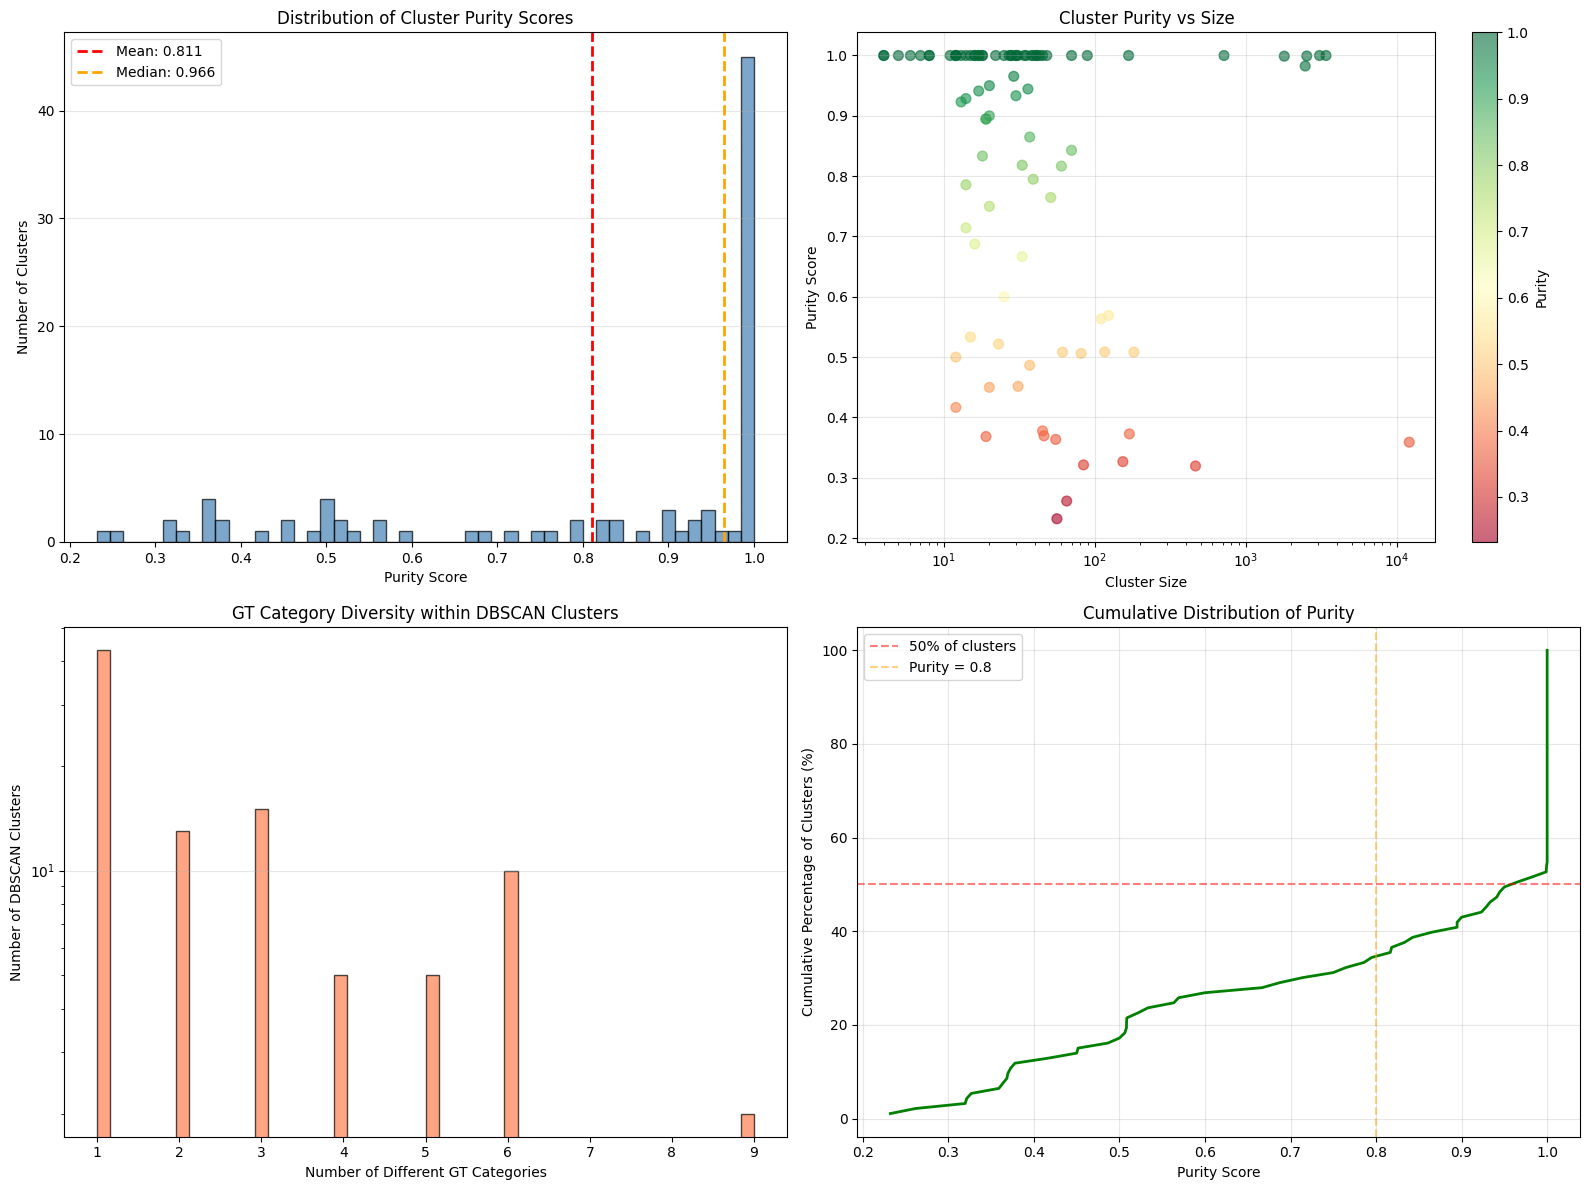

ENHANCED CLUSTER PURITY ANALYSIS
Total clusters analyzed: 93

Purity Statistics:
  Mean purity: 0.811
  Median purity: 0.966
  Std deviation: 0.248

Purity Thresholds:
  Clusters with purity ≥ 0.9: 54 (58.1%)
  Clusters with purity ≥ 0.8: 61 (65.6%)
  Clusters with purity ≥ 0.7: 66 (71.0%)
  Clusters with purity ≥ 0.5: 78 (83.9%)

GT Category Diversity:
  Mean GT categories per DBSCAN cluster: 2.5
  Median GT categories per DBSCAN cluster: 2
  Max GT categories in one DBSCAN cluster: 9

🏆 TOP 10 MOST PURE CLUSTERS:
----------------------------------------------------------------------------------------------------
    37 | Size: 3385 | Purity: 1.000 | Dominant: CPUs
    70 | Size: 3065 | Purity: 1.000 | Dominant: Washing Machines
    64 | Size: 715 | Purity: 1.000 | Dominant: Dishwashers
    83 | Size: 167 | Purity: 1.000 | Dominant: Fridge Freezers
    53 | Size:  89 | Purity: 1.000 | Dominant: Microwaves
    69 | Size:  70 | Purity: 1.000 | Dominant: Dishwashers
     6 | Size:  48 | 

In [29]:
if len(results_valid) > 0 and len(purity_df) > 0:
    # Calculate enhanced purity metrics
    # Purity = (size of largest GT category) / (total cluster size)

    enhanced_purity_data = []

    for cluster_id in cluster_sizes_no_noise.index:
        cluster_data = product[product['DBSCAN_Cluster'] == cluster_id]
        
        # Get ground truth distribution
        gt_distribution = cluster_data[' Category ID'].value_counts()
        
        # Calculate purity
        largest_gt_count = gt_distribution.max()
        cluster_size = len(cluster_data)
        purity = largest_gt_count / cluster_size
        
        # Get dominant GT category info
        dominant_gt_id = gt_distribution.idxmax()
        dominant_gt_label = cluster_data[cluster_data[' Category ID'] == dominant_gt_id][' Category Label'].iloc[0]
        
        enhanced_purity_data.append({
            'DBSCAN_Cluster': cluster_id,
            'Size': cluster_size,
            'Purity': purity,
            'Dominant_GT_ID': dominant_gt_id,
            'Dominant_GT_Label': dominant_gt_label,
            'Dominant_GT_Count': largest_gt_count,
            'Num_GT_Categories': len(gt_distribution)
        })

    enhanced_purity_df = pd.DataFrame(enhanced_purity_data)

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Purity distribution
    ax1 = axes[0, 0]
    ax1.hist(enhanced_purity_df['Purity'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.axvline(enhanced_purity_df['Purity'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {enhanced_purity_df["Purity"].mean():.3f}')
    ax1.axvline(enhanced_purity_df['Purity'].median(), color='orange', linestyle='--', linewidth=2, 
                label=f'Median: {enhanced_purity_df["Purity"].median():.3f}')
    ax1.set_xlabel('Purity Score')
    ax1.set_ylabel('Number of Clusters')
    ax1.set_title('Distribution of Cluster Purity Scores')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: Purity vs Cluster Size
    ax2 = axes[0, 1]
    scatter = ax2.scatter(enhanced_purity_df['Size'], enhanced_purity_df['Purity'], alpha=0.6, s=50, 
                         c=enhanced_purity_df['Purity'], cmap='RdYlGn')
    ax2.set_xlabel('Cluster Size')
    ax2.set_ylabel('Purity Score')
    ax2.set_title('Cluster Purity vs Size')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax2, label='Purity')

    # Plot 3: Number of GT categories per DBSCAN cluster
    ax3 = axes[1, 0]
    ax3.hist(enhanced_purity_df['Num_GT_Categories'], bins=50, color='coral', edgecolor='black', alpha=0.7)
    ax3.set_xlabel('Number of Different GT Categories')
    ax3.set_ylabel('Number of DBSCAN Clusters')
    ax3.set_title('GT Category Diversity within DBSCAN Clusters')
    ax3.set_yscale('log')
    ax3.grid(axis='y', alpha=0.3)

    # Plot 4: Cumulative purity
    ax4 = axes[1, 1]
    sorted_purity = np.sort(enhanced_purity_df['Purity'])
    cumulative = np.arange(1, len(sorted_purity) + 1) / len(sorted_purity) * 100
    ax4.plot(sorted_purity, cumulative, linewidth=2, color='green')
    ax4.axhline(50, color='red', linestyle='--', alpha=0.5, label='50% of clusters')
    ax4.axvline(0.8, color='orange', linestyle='--', alpha=0.5, label='Purity = 0.8')
    ax4.set_xlabel('Purity Score')
    ax4.set_ylabel('Cumulative Percentage of Clusters (%)')
    ax4.set_title('Cumulative Distribution of Purity')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistics
    print("=" * 100)
    print("ENHANCED CLUSTER PURITY ANALYSIS")
    print("=" * 100)
    print(f"Total clusters analyzed: {len(enhanced_purity_df)}")
    print(f"\nPurity Statistics:")
    print(f"  Mean purity: {enhanced_purity_df['Purity'].mean():.3f}")
    print(f"  Median purity: {enhanced_purity_df['Purity'].median():.3f}")
    print(f"  Std deviation: {enhanced_purity_df['Purity'].std():.3f}")
    print(f"\nPurity Thresholds:")
    for threshold in [0.9, 0.8, 0.7, 0.5]:
        count = (enhanced_purity_df['Purity'] >= threshold).sum()
        pct = (count / len(enhanced_purity_df)) * 100
        print(f"  Clusters with purity ≥ {threshold}: {count} ({pct:.1f}%)")

    print(f"\nGT Category Diversity:")
    print(f"  Mean GT categories per DBSCAN cluster: {enhanced_purity_df['Num_GT_Categories'].mean():.1f}")
    print(f"  Median GT categories per DBSCAN cluster: {enhanced_purity_df['Num_GT_Categories'].median():.0f}")
    print(f"  Max GT categories in one DBSCAN cluster: {enhanced_purity_df['Num_GT_Categories'].max()}")

    # Show most pure clusters
    print(f"\n🏆 TOP 10 MOST PURE CLUSTERS:")
    print("-" * 100)
    top_pure = enhanced_purity_df.nlargest(10, 'Purity')
    for i, row in top_pure.iterrows():
        print(f"  {row['DBSCAN_Cluster']:4d} | Size: {row['Size']:3d} | Purity: {row['Purity']:.3f} | "
              f"Dominant: {row['Dominant_GT_Label']}")

    # Show least pure (most mixed) clusters
    print(f"\n⚠️  TOP 10 LEAST PURE (MOST MIXED) CLUSTERS:")
    print("-" * 100)
    least_pure = enhanced_purity_df.nsmallest(10, 'Purity')
    for i, row in least_pure.iterrows():
        print(f"  {row['DBSCAN_Cluster']:4d} | Size: {row['Size']:3d} | Purity: {row['Purity']:.3f} | "
              f"{row['Num_GT_Categories']} GT categories mixed")

    print("=" * 100)


### 10.6 Word Cloud Analysis - Visualize Cluster Themes

Generate word clouds for selected clusters to see common terms.

🎨 Generating word clouds for top 6 largest clusters...

  Generating word cloud for cluster 17...
  Generating word cloud for cluster 37...
  Generating word cloud for cluster 70...
  Generating word cloud for cluster 37...
  Generating word cloud for cluster 70...
  Generating word cloud for cluster 0...
  Generating word cloud for cluster 7...
  Generating word cloud for cluster 0...
  Generating word cloud for cluster 7...
  Generating word cloud for cluster 34...
  Generating word cloud for cluster 34...


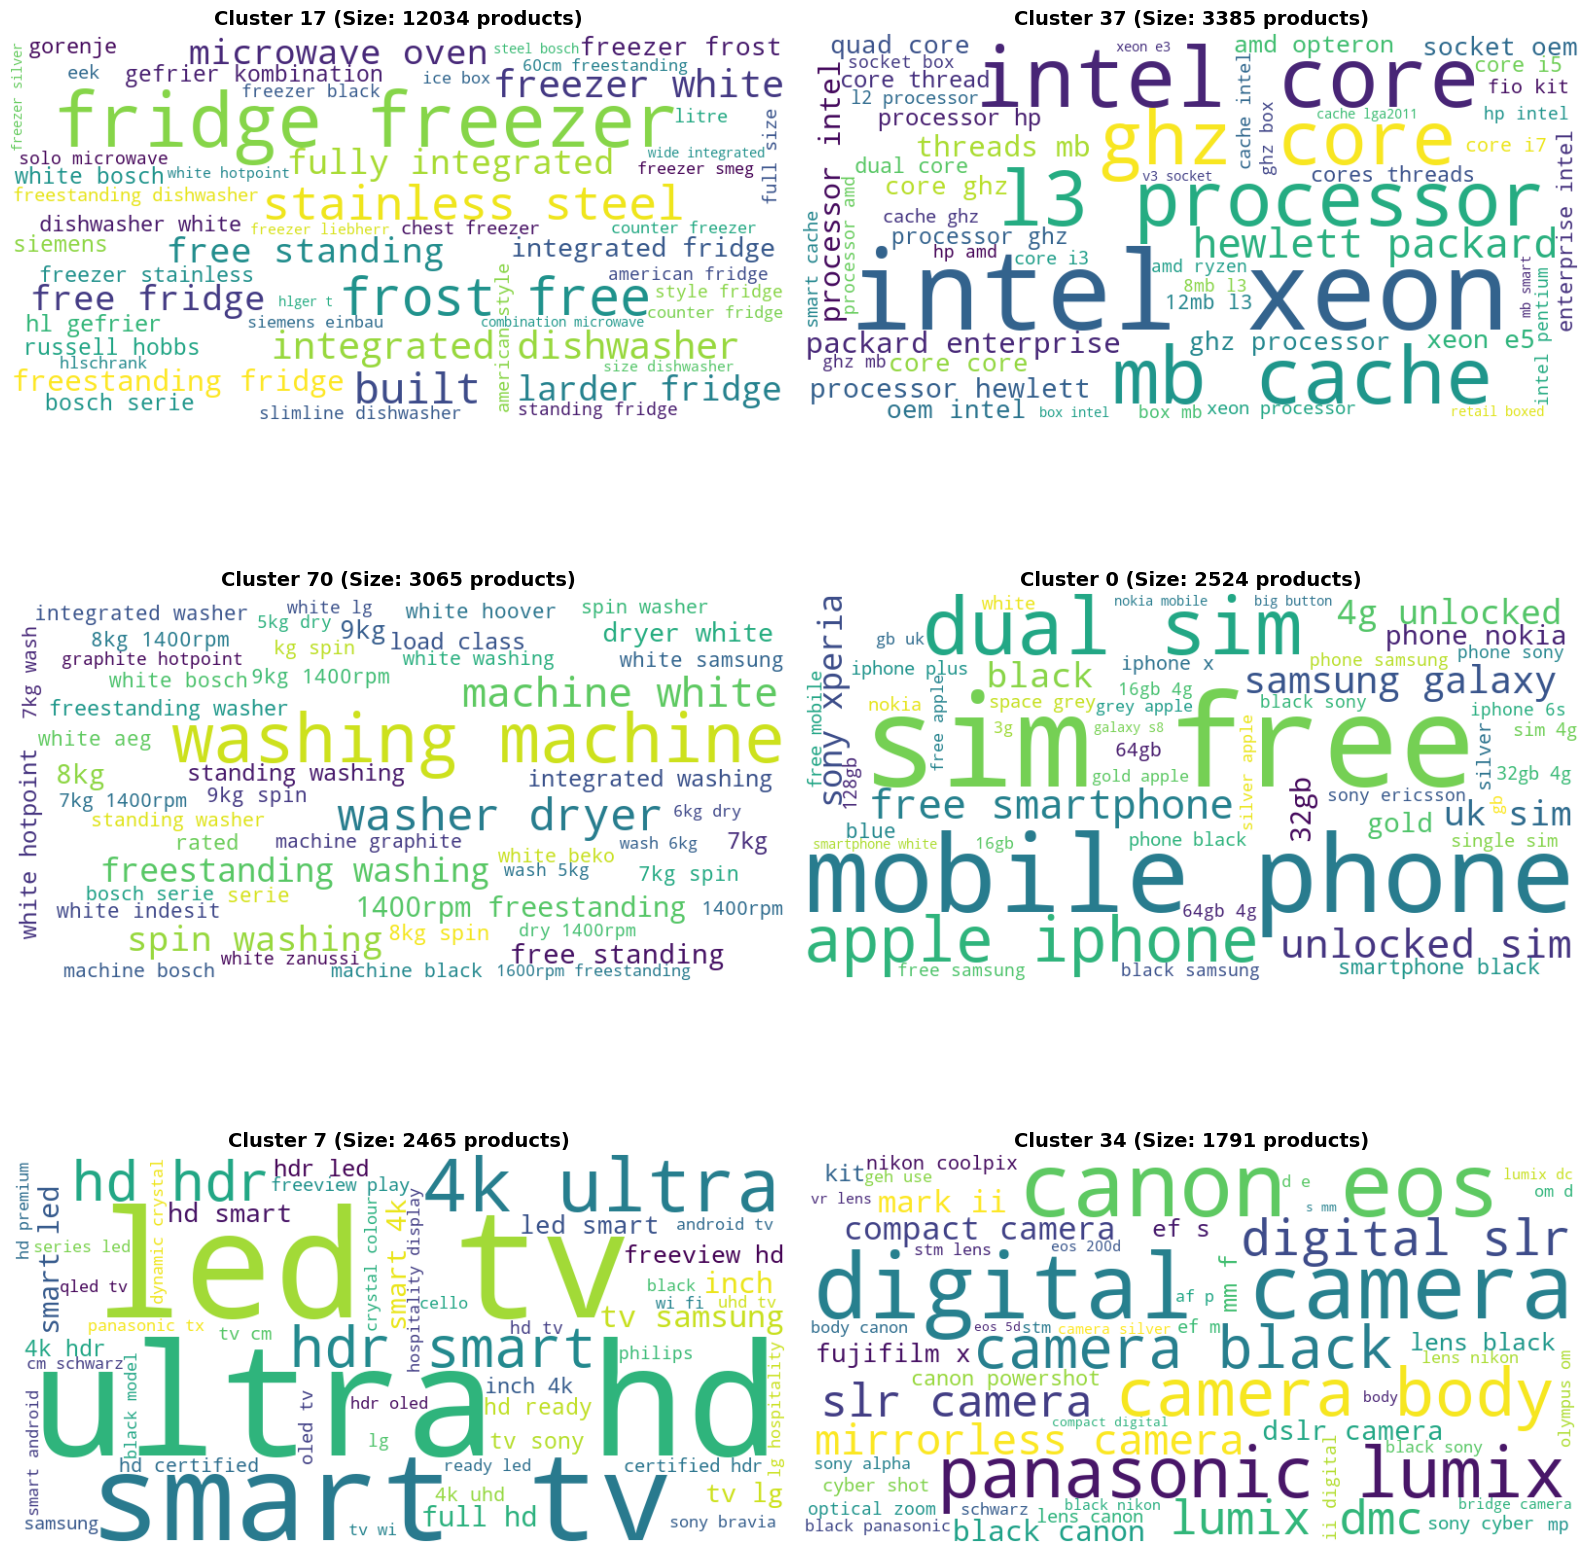


✅ Word clouds generated! Look for:
   • Dominant product brands/models
   • Common attributes (color, size, capacity)
   • Product categories


In [30]:
if len(results_valid) > 0:
    # Optional: Install wordcloud if not already installed
    # !pip install wordcloud

    try:
        from wordcloud import WordCloud
        
        # Function to generate word cloud for a cluster
        def generate_wordcloud_for_cluster(cluster_id, ax=None):
            """Generate word cloud from product titles in a cluster"""
            cluster_data = product[product['DBSCAN_Cluster'] == cluster_id]
            
            # Combine all titles
            all_text = ' '.join(cluster_data['Product Title'].str.lower())
            
            # Generate word cloud
            wordcloud = WordCloud(
                width=800, 
                height=400,
                background_color='white',
                colormap='viridis',
                max_words=50,
                relative_scaling=0.5
            ).generate(all_text)
            
            # Plot
            if ax is None:
                plt.figure(figsize=(12, 6))
                ax = plt.gca()
            
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.axis('off')
            ax.set_title(f'Cluster {cluster_id} (Size: {len(cluster_data)} products)', fontsize=14, fontweight='bold')
            
            return wordcloud
        
        # Generate word clouds for top 6 largest clusters
        top_clusters_for_wordcloud = cluster_sizes_no_noise.head(6).index
        
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        axes = axes.flatten()
        
        print("🎨 Generating word clouds for top 6 largest clusters...\n")
        
        for idx, cluster_id in enumerate(top_clusters_for_wordcloud):
            print(f"  Generating word cloud for cluster {cluster_id}...")
            generate_wordcloud_for_cluster(cluster_id, ax=axes[idx])
        
        plt.tight_layout()
        plt.show()
        
        print("\n✅ Word clouds generated! Look for:")
        print("   • Dominant product brands/models")
        print("   • Common attributes (color, size, capacity)")
        print("   • Product categories")
        
    except ImportError:
        print("⚠️  WordCloud library not installed.")
        print("To install: !pip install wordcloud")
        print("Skipping word cloud visualization...")

### 10.7 Manual Coherence Scoring (Interactive)

For a truly qualitative assessment, manually score a random sample of clusters.

In [31]:
if len(results_valid) > 0 and len(purity_df) > 0:
    # Sample 10 random clusters of varying sizes for manual inspection
    print("=" * 100)
    print("MANUAL COHERENCE EVALUATION - SAMPLE 10 RANDOM CLUSTERS")
    print("=" * 100)
    print("\nFor each cluster, evaluate:")
    print("  1. Do products look similar/related based on titles?")
    print("  2. Would you group these products together?")
    print("  3. Rate coherence: High (most products similar) / Medium / Low (mixed/unrelated)")
    print("\n" + "=" * 100 + "\n")

    # Sample clusters from different sizes
    sample_clusters = []

    # 3 from large (top 25%)
    large_threshold = purity_df['Size'].quantile(0.75)
    large_clusters = purity_df[purity_df['Size'] >= large_threshold]['DBSCAN_Cluster'].values
    if len(large_clusters) >= 3:
        sample_clusters.extend(np.random.choice(large_clusters, 3, replace=False))

    # 4 from medium (25-75%)
    medium_min = purity_df['Size'].quantile(0.25)
    medium_max = purity_df['Size'].quantile(0.75)
    medium_clusters = purity_df[
        (purity_df['Size'] >= medium_min) & (purity_df['Size'] < medium_max)
    ]['DBSCAN_Cluster'].values
    if len(medium_clusters) >= 4:
        sample_clusters.extend(np.random.choice(medium_clusters, 4, replace=False))

    # 3 from small (bottom 25%)
    small_threshold = purity_df['Size'].quantile(0.25)
    small_clusters = purity_df[purity_df['Size'] < small_threshold]['DBSCAN_Cluster'].values
    if len(small_clusters) >= 3:
        sample_clusters.extend(np.random.choice(small_clusters, 3, replace=False))

    # Display each cluster for manual evaluation
    for idx, cluster_id in enumerate(sample_clusters, 1):
        cluster_data = product[product['DBSCAN_Cluster'] == cluster_id]
        cluster_info = purity_df[purity_df['DBSCAN_Cluster'] == cluster_id].iloc[0]
        
        print(f"\n{'=' * 100}")
        print(f"CLUSTER {idx}/10 | DBSCAN Cluster ID: {cluster_id}")
        print(f"Size: {len(cluster_data)} products | Purity: {cluster_info['Purity']:.3f} | "
              f"GT Clusters Mixed: {cluster_info['Num_GT_Merged']}")
        print(f"{'=' * 100}\n")
        
        # Show all products (or sample if too large)
        display_sample = cluster_data.sample(n=min(15, len(cluster_data)), random_state=42)
        
        for i, (_, row) in enumerate(display_sample.iterrows(), 1):
            print(f"  {i:2d}. {row['Product Title']}")
        
        if len(cluster_data) > 15:
            print(f"  ... and {len(cluster_data) - 15} more products")
        
        print(f"\n  💭 YOUR ASSESSMENT: [ ] High coherence  [ ] Medium coherence  [ ] Low coherence")
        print(f"  📝 NOTES: _________________________________________________________________")
        print()

    print("\n" + "=" * 100)
    print("✅ Manual evaluation complete!")
    print("\nSummary questions:")
    print("  • What % of clusters have HIGH coherence (products clearly related)?")
    print("  • What % have MEDIUM coherence (somewhat related, or mixed)?")
    print("  • What % have LOW coherence (seems random/poorly clustered)?")
    print("  • Overall, does DBSCAN produce meaningful groupings for YOUR use case?")
    print("=" * 100)

MANUAL COHERENCE EVALUATION - SAMPLE 10 RANDOM CLUSTERS

For each cluster, evaluate:
  1. Do products look similar/related based on titles?
  2. Would you group these products together?
  3. Rate coherence: High (most products similar) / Medium / Low (mixed/unrelated)



CLUSTER 1/10 | DBSCAN Cluster ID: 83
Size: 167 products | Purity: 1.000 | GT Clusters Mixed: 1.0

   1. smeg sbs63xed silver side by side fridge freezer with stainless steel doors
   2. hisense rs696n4ib1 side by side american frost free fridge freezer with ice and water dispenser black
   3. fisher paykel rx628dx1 american fridge freezer in stainless steel ice maker side by side 24449
   4. liebherr sbsbs8673 blacksteel side by side fridge freezer food centre
   5. hisense rf528n4wb1 frost free american style side by side fridge freezer black
   6. lg gsl760pzxv frost free side by side american fridge freezer shiny steel
   7. cda pc52sc american style side by side fridge freezer a rated stainless colour
   8. hisense

---

## 📊 Qualitative Evaluation Summary

### How to Interpret Results:

**✅ Good Signs (DBSCAN is working):**
- High purity scores (≥0.7) for most clusters
- Cluster samples show clear product similarity
- Noise points are genuinely unique/outlier products
- Word clouds show coherent themes per cluster
- Manual inspection reveals meaningful groupings

**⚠️ Warning Signs (May need adjustments):**
- Low average purity (<0.5)
- Clusters mix unrelated products
- Too many noise points (>40%)
- Manual inspection shows random groupings

**🔧 What to Try Next:**
1. **Adjust parameters** - Try different eps/min_samples from grid search
2. **Better embeddings** - Use BERT/Sentence-BERT instead of TF-IDF
3. **Try HDBSCAN** - Adapts to varying density automatically
4. **Feature engineering** - Add brand, category, price info
5. **Accept the results** - If clusters make business sense, low ARI is OK!

### Key Question:
**Does DBSCAN produce clusters that are useful for YOUR downstream task?**
- Product recommendation? Duplicate detection? Categorization?
- If yes → Success! (regardless of ARI score)
- If no → Time to try alternatives